# Transcription Factor Project
**Robin Anwyl, UCSD Subramaniam Lab, Winter Quarter 2025**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Guiding Questions:**
*  What TF KOs are present in the dataset? 
*  When performing clustering with the dataset - can we associate a unique set of TFs with a cluster? Is there any functional significance to these clusters?
*  What gene targets are associated with these TFs?
*  Which TFs are involved in co-regulation, and which genes are co-regulated? Which TFs are regulated by other TFs?
*  How do TFs influence chromatin remodeling? Which sets of writers and erasers are regulated by these TFs?

***

# Import statements

In [1]:
import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import re
import requests
import gc
from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
import seaborn as sns
import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import networkx as nx
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
#import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2
# import json

Note: use terminal command " watch -n 0.1 free -h " to watch how much memory is being used

# QC pipeline

## Initial data read-in

We will read in the Perturb-seq single-cell dataset `.h5mu` file as a `MuData` object, `mdata`.

`mdata` contains two modalities which are `AnnData` objects: `rna` (cell-by-gene matrix) and `crispr` (cell-by-knockout matrix)
- `rna`: 5386783 cells x 38606 features  
    - Features = expression of each human gene measured in the dataset
    - `.obs` = cell barcodes, `.var` = features = genes
- `crispr`: 5386783 cells x 35989 features
    - Features = CRISPR sgRNAs (3 sgRNAs per gene target * 11739 gene targets, plus 478 non-targeting control sgRNAs)
    - `.obs` = cell barcodes, `.var` = features = knockouts

We will be working with the `rna` modality for the majority of the analysis. We will assign it to the variable `adata`.

In [ ]:
md_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Aggregate.h5mu"
mdata = mu.read_h5mu(md_filepath)
adata = mdata.mod["rna"]

In [ ]:
crispr = mdata.mod['crispr']

## Running pipeline

Note: functions written in `Pan_Genome_Analysis.ipynb` have been pasted into a file `pan_genome_analysis_functions.py` that is imported as `qc2`

### Step B: Assigning sgRNA to cells and de facto doublet detection

The lists of cells and genes provided by the Mali lab are the output of step D; however, steps E through F require metadata annotation, meaning that it would make the most sense to run the pipeline on the `KOLF_Pan_Genome_Aggregate.h5mu` file through step F. First, we will run step B: assigning sgRNA to cells based on the protospacer calls and removing cells without exactly one sgRNA assigned.

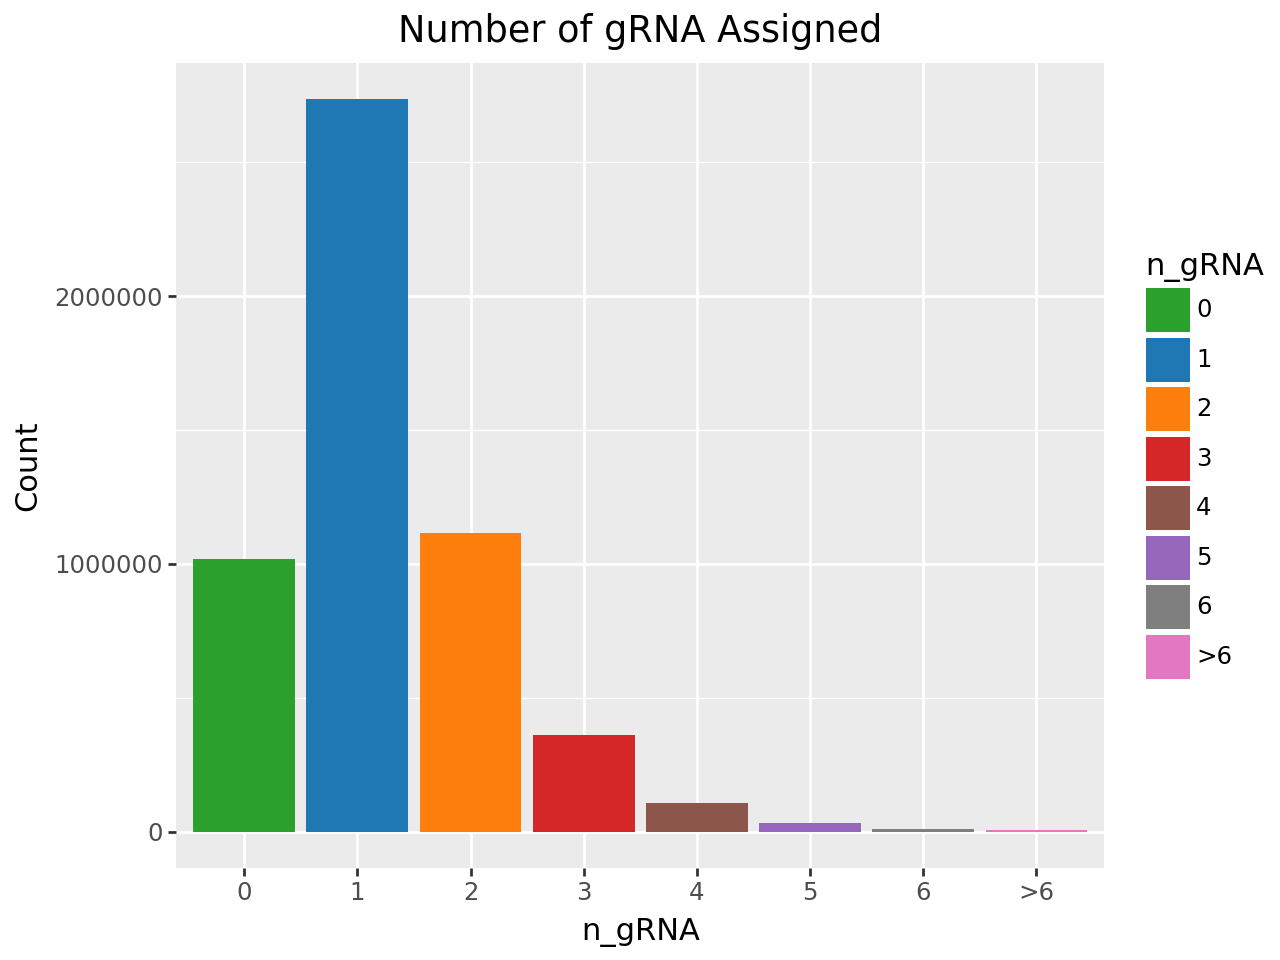

Cells without confident sgRNA calls: 18.89%
Estimated Multiplet Rate: 30.33%


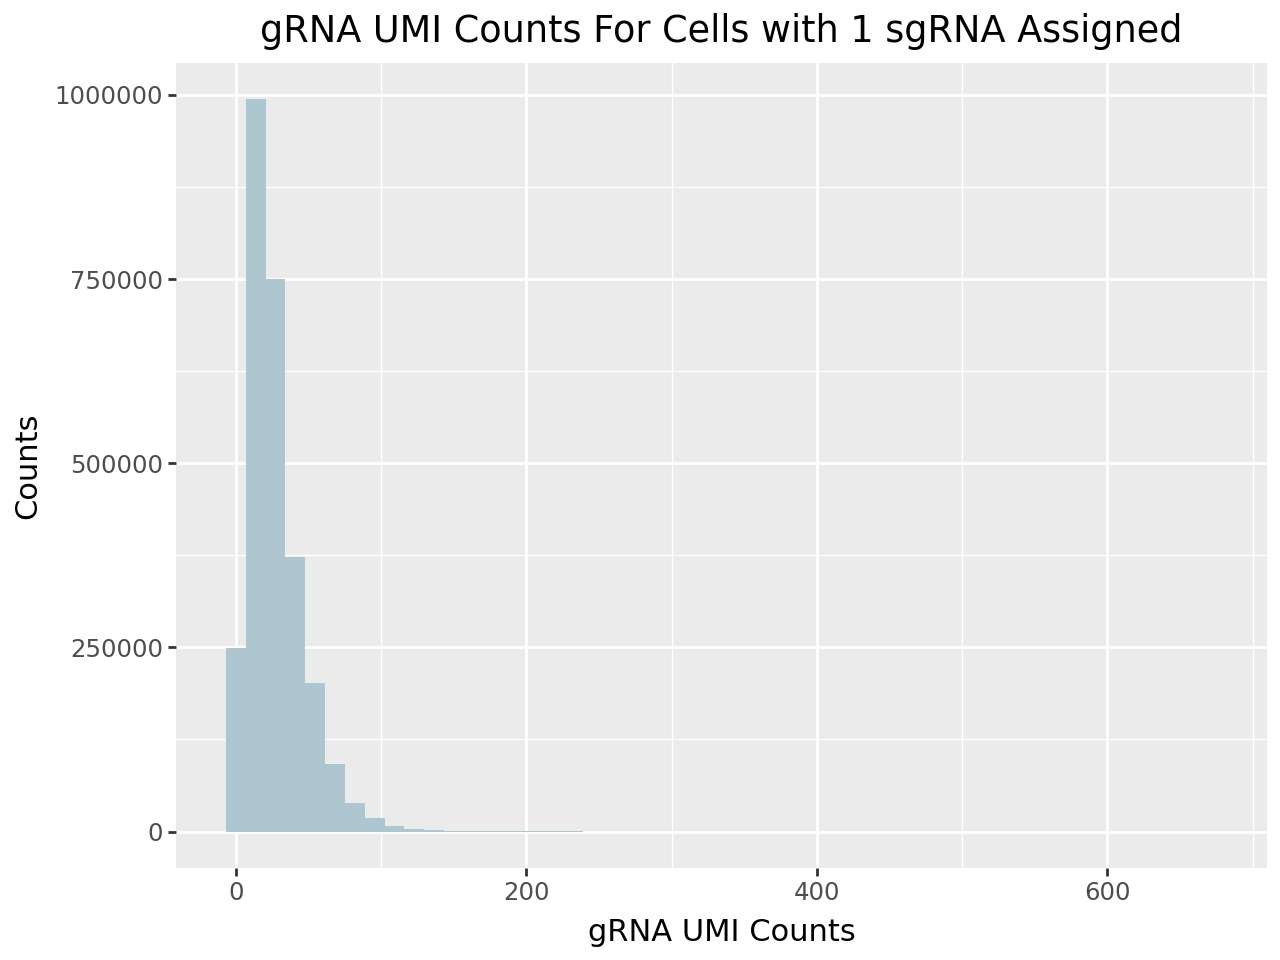

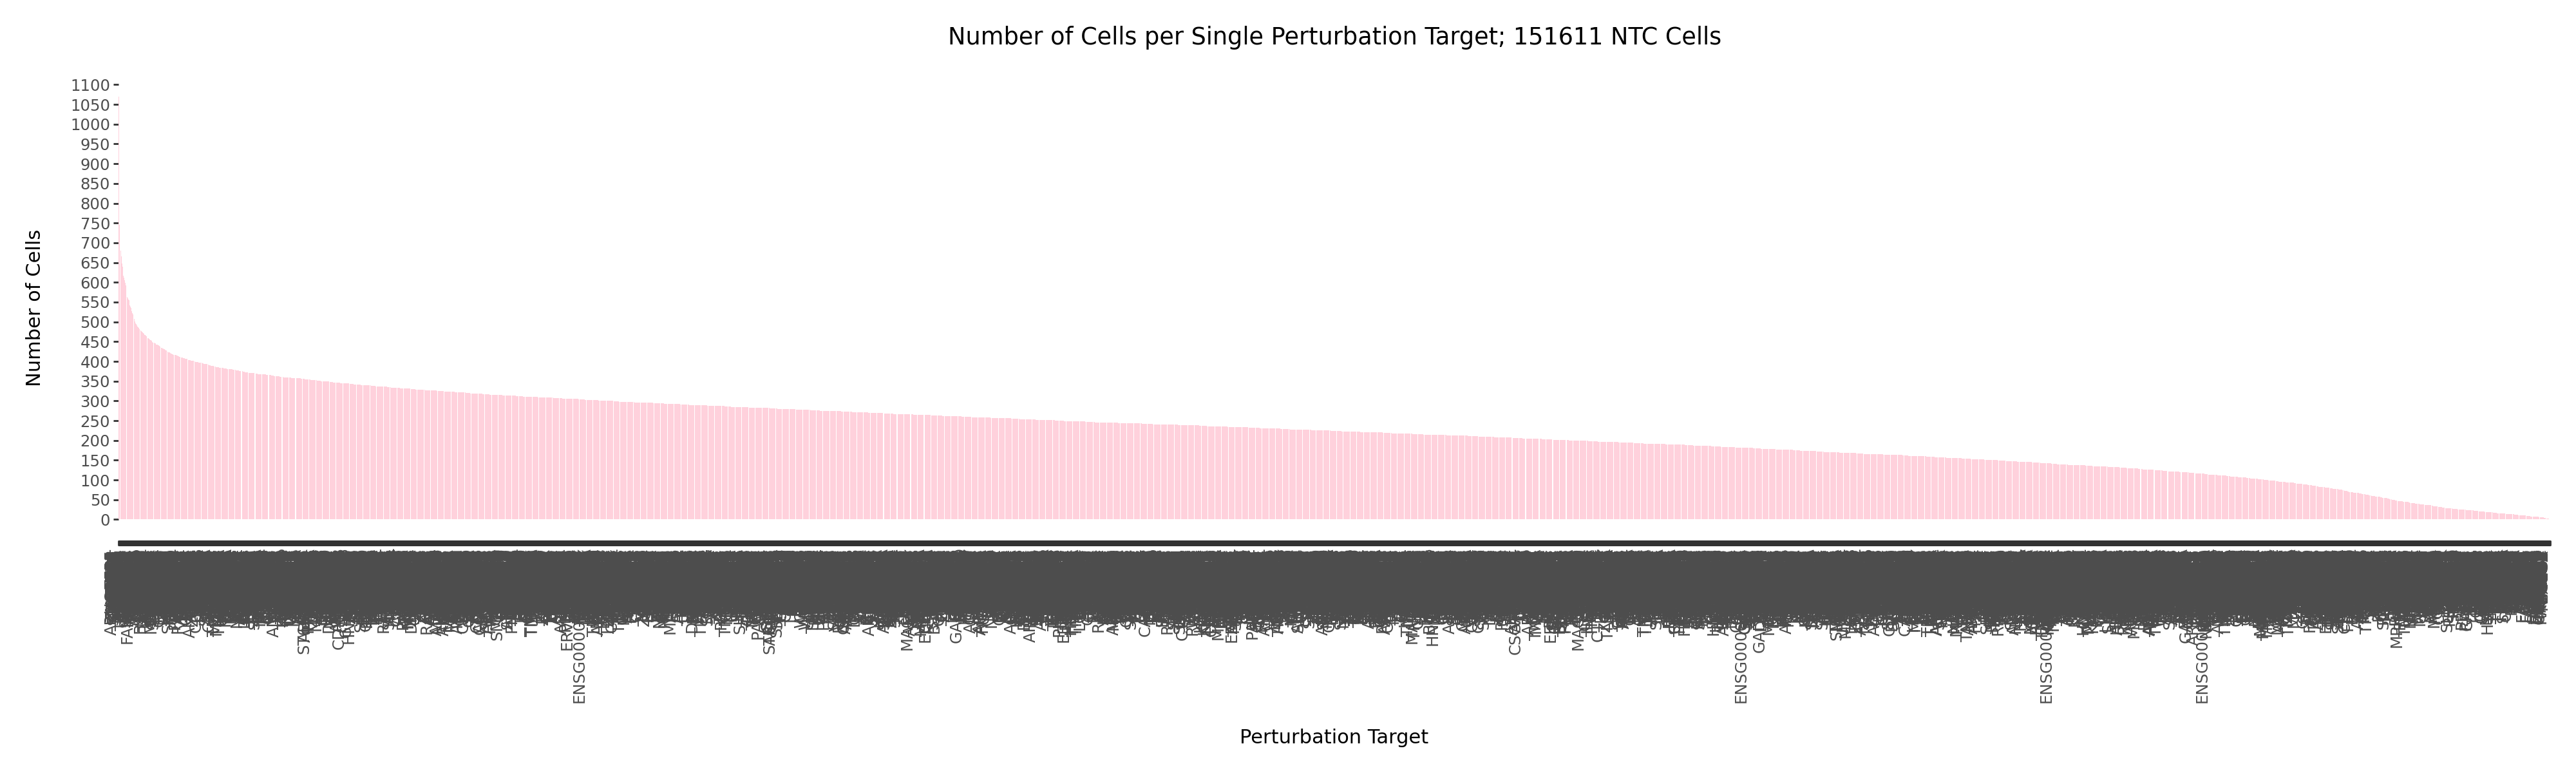

Number of perturbations with >= 50 cells with single guide assigned: 10933/11687 (93.55%)


In [ ]:
protospacer_calls_file_path = "/home/ranwyl/data_tf_project/protospacer_calls_per_cell.csv"
adata = qc.assign_protospacers(adata,protospacer_calls_file_path=protospacer_calls_file_path)

### Step C: Cell-level QC

Now we will run step C, cell-level QC. First, we assign metadata:

In [ ]:
aggregation_csv_file_path = "/home/ranwyl/data_tf_project/aggregation_csv.csv"
d = pd.read_csv(aggregation_csv_file_path)
channel_dict = {str(i+1):channel for i,channel in enumerate(d["sample_id"])}
adata = qc.assign_metadata(adata=adata,cell_type="KOLF2.1J iPSC",perturbation_type="CRISPRi Perturb-Seq",channel_dict=channel_dict)
adata.obs['n_gRNA_UMIs'] = adata.obs['n_gRNA_UMIs'].astype(str)

/home/ranwyl/data_tf_project/perturb_seq_heuristic_pipeline.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [ ]:
adata

AnnData object with n_obs × n_vars = 2735450 × 38606
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

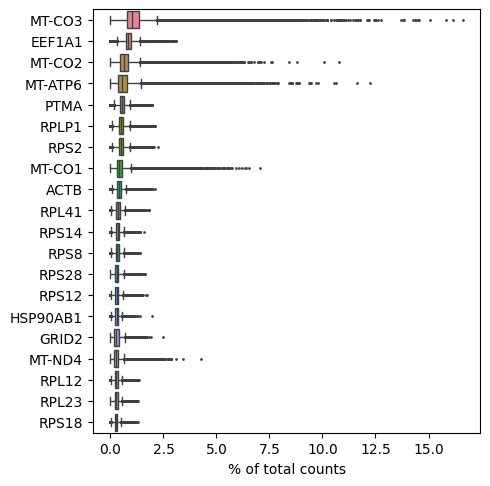

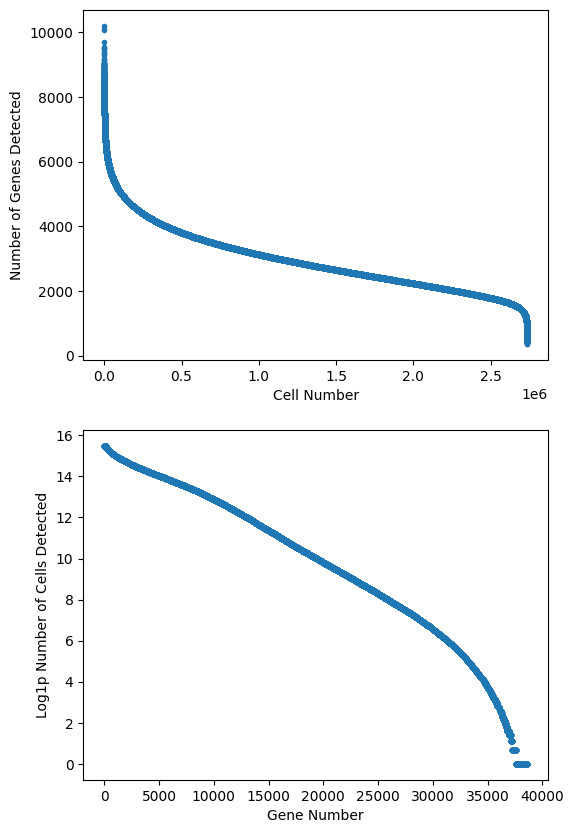

Removing 1039 genes not detected in any cells.


In [ ]:
adata = qc.general_qc(adata)

/home/ranwyl/data_tf_project/perturb_seq_heuristic_pipeline.py:201: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


outlier
False    2663490
True       71960
Name: count, dtype: int64

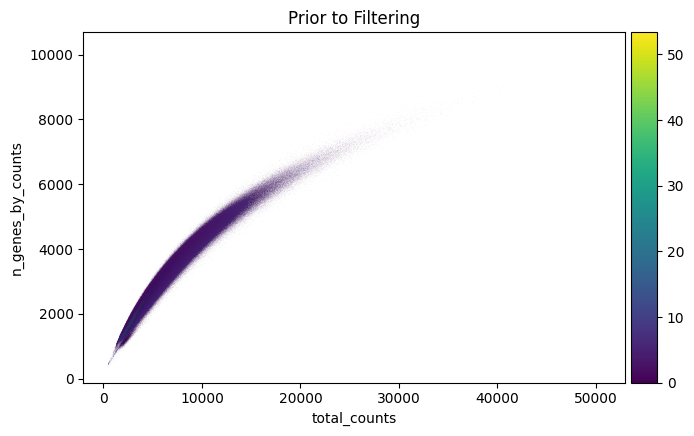

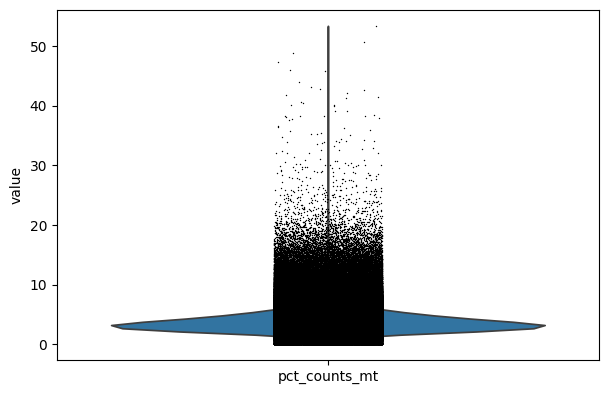

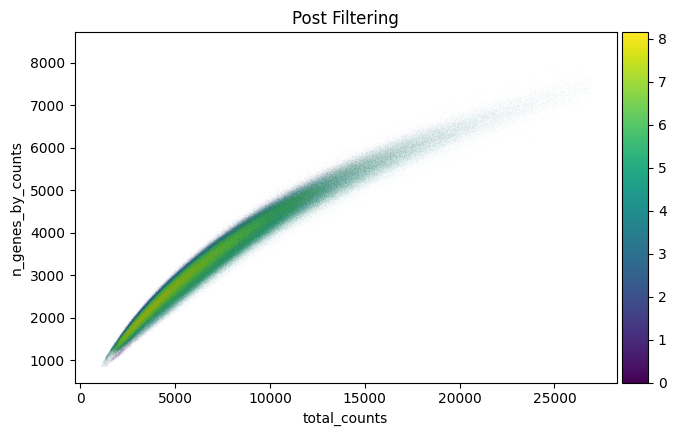

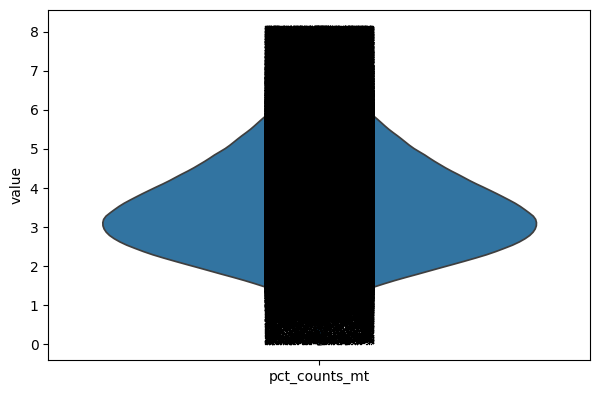

In [ ]:
adata = qc.dead_cell_qc(adata, mt_MADs=5)

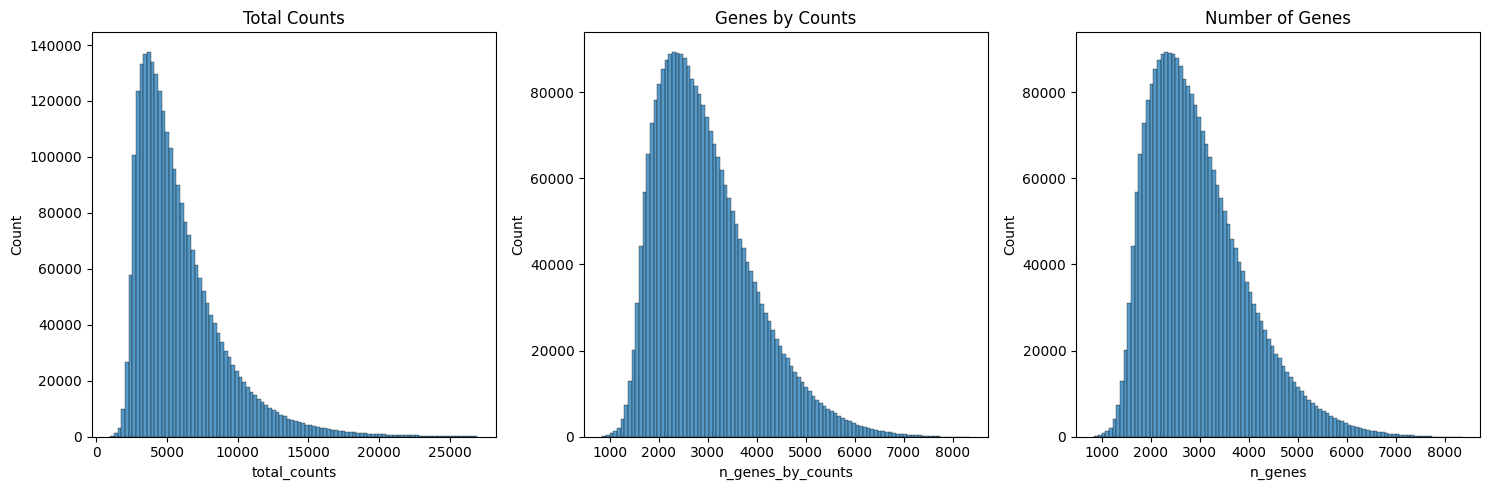

In [ ]:
qc.doublet_detection_sanity_check(adata)

Save the intermediate file:

In [ ]:
adata.write("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad") # Deleted already

### Step D: Isolating Core NTC Cells 

Read in QC-passed data:

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad")

Save raw counts and create `run` metadata column in `obs`:

In [ ]:
adata.layers["counts"] = adata.X.copy()
adata.obs["run"] = [label.split('-')[0] for label in adata.obs.channel]

Filter NTC cells based on provided whitelist:

In [ ]:
whitelist_filepath = "/home/ranwyl/data_tf_project/NTC_sgRNA_whitelist.txt"
with open(whitelist_filepath, 'r') as f:
  sgRNA_whitelist = f.read().splitlines()
ntc_adata = qc2._get_ntc_view(adata)
ntc_adata = ntc_adata[ntc_adata.obs.gRNA.isin(sgRNA_whitelist)].copy()
ntc_adata

AnnData object with n_obs × n_vars = 53476 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Use isolation forest with 30% contamination fraction to isolate core NTC cells:

Initial number of NTC Cells: 53476
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    342 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    300 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=100
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_r

  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:34)


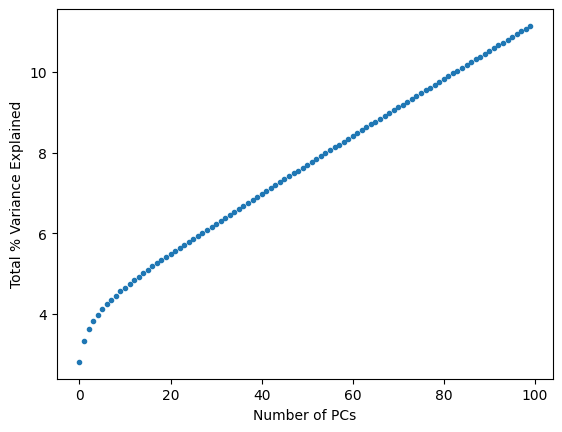

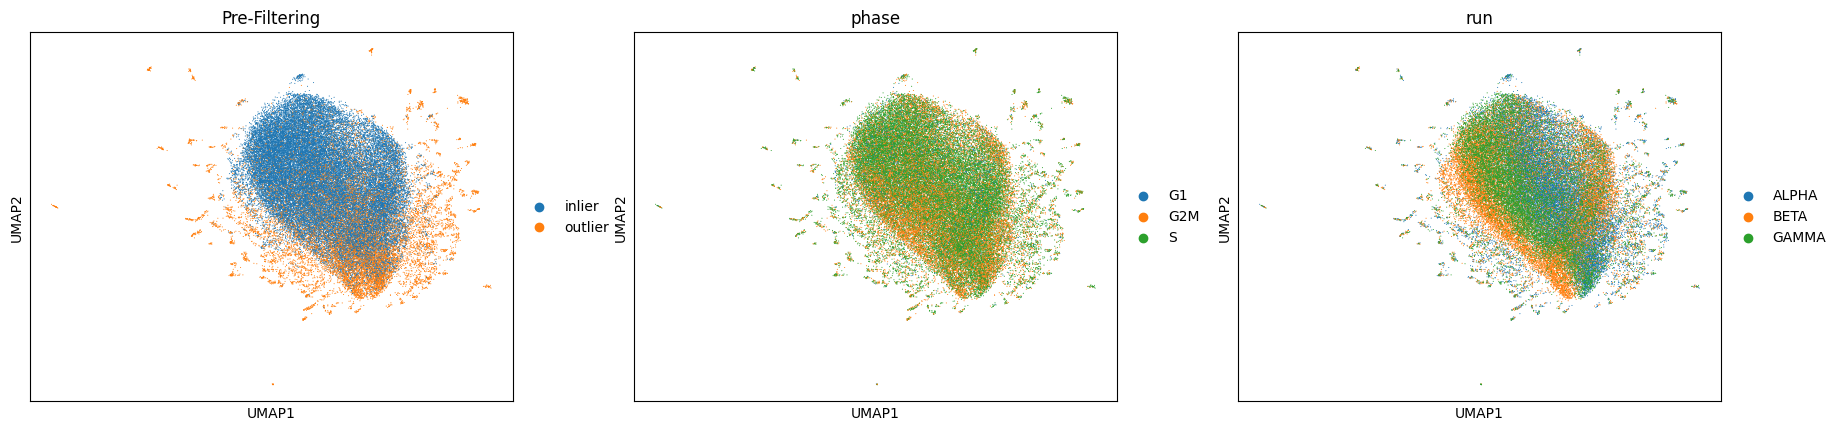

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


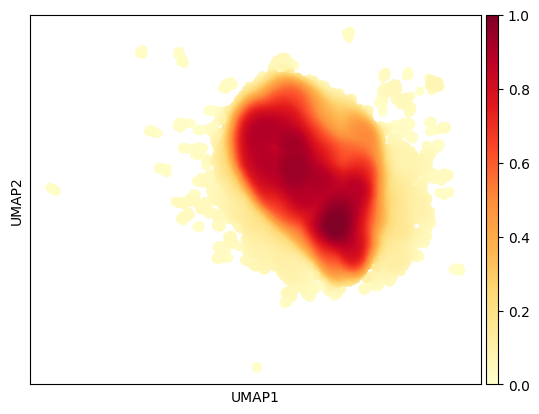

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:04)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:34)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


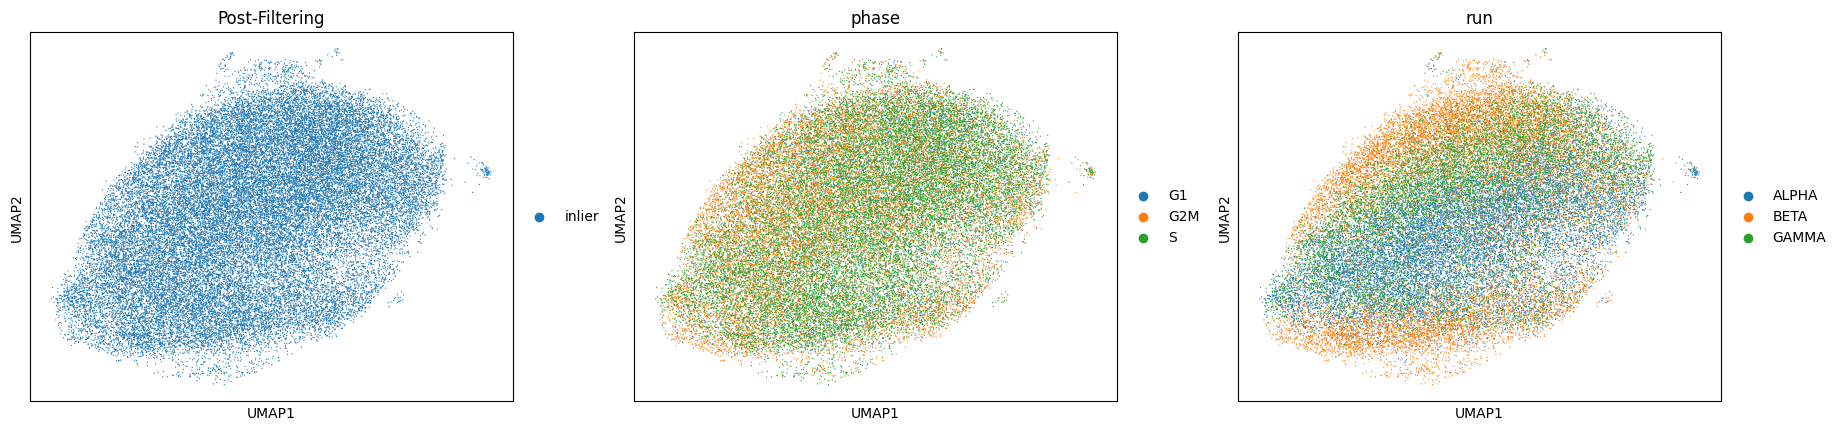

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


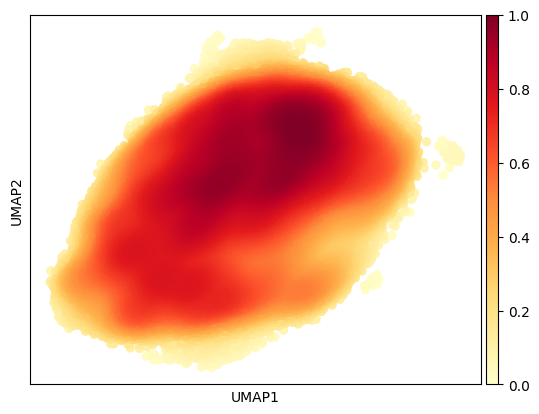

In [ ]:
ntc_adata = ntc_adata[ntc_adata.obs.index.isin(qc2.scrub_ntc(ntc_adata))]

In [ ]:
ntc_adata

View of AnnData object with n_obs × n_vars = 37433 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'S_score', 'G2M_score', 'phase', 'is_outlier', 'umap_density'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'is_outlier_colors', 'phase_colo

In [ ]:
ntc_adata.obs.run.value_counts()

run
ALPHA    14108
BETA     13537
GAMMA     9788
Name: count, dtype: int64

Note: the above counts are slightly different than the Pan_Genome_Analysis.ipynb notebook.

We have now isolated the core NTC cells. We will subset `adata` to only include perturbed cells and the core NTC cells.

In [ ]:
perturbed_mask = adata.obs.perturbed == "True"
valid_ntc_mask = adata.obs.index.isin(ntc_adata.obs.index)
adata_step_d = adata[perturbed_mask | valid_ntc_mask,:].copy()

In [ ]:
adata_step_d

AnnData object with n_obs × n_vars = 2554182 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Save the file:

In [ ]:
adata_step_d.write("/home/ranwyl/data_tf_project/Aggregate_Core_NTC.h5ad")

### Post step D/pre step E

Load in data:

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Core_NTC.h5ad")

Check that the number of NTC cells is correct:

In [ ]:
adata[adata.obs["perturbed"] == "False"]

View of AnnData object with n_obs × n_vars = 37433 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Plot cells per perturbation:

10281/11739 (87.58)% Perturbations have > 100 cells


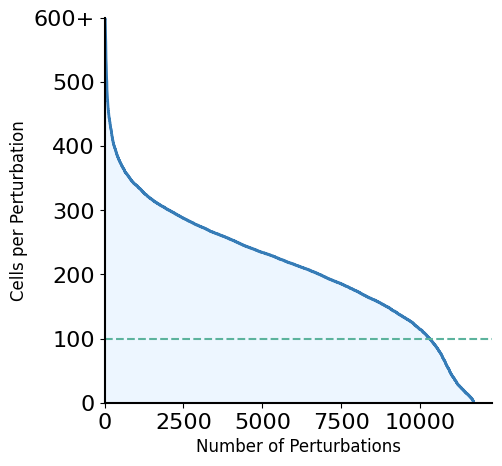

In [ ]:
f = qc2.plot_cells_per_perturbation(adata)

Plot UMIs per cell:

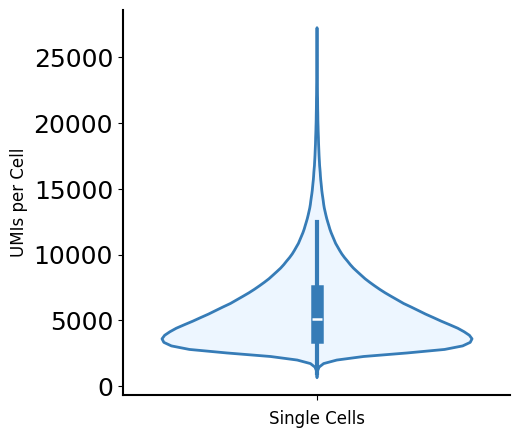

In [ ]:
f = qc2.plot_umis_per_cell(adata)

Assign more metadata:

In [ ]:
gene_id_file_path = "/home/ranwyl/data_tf_project/gene_ids.txt"
qc2.assign_gene_ids(adata, gene_id_file_path)
adata = qc2.remove_invalid_gene_targets_in_place(adata,obs_key="gene_target_ensembl_id",var_key="gene_ids")

  - ENSG00000234414
  - ENSG00000251380
  - ENSG00000182415
  - ENSG00000172288
  - ENSG00000262664
  - ENSG00000129864
  - ENSG00000268994
  - ENSG00000286190
  - ENSG00000253797


Split by run and save intermediate files:

In [ ]:
adata_alpha = adata[adata.obs.run=="ALPHA"]
adata_alpha = adata_alpha.copy()
adata_alpha.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA.h5ad")

In [ ]:
adata_beta = adata[adata.obs.run=="BETA"]
adata_beta = adata_beta.copy()
adata_beta.write("/home/ranwyl/data_tf_project/Aggregate_BETA.h5ad")

In [ ]:
adata_gamma = adata[adata.obs.run=="GAMMA"]
adata_gamma = adata_gamma.copy()
adata_gamma.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA.h5ad")

### Step E: Isolating effective sgRNA

In this step, we will normalize counts per cell to 1M, remove sgRNA that do not induce mean >30% on-target knockdown, and remove unrepressed cells and sgRNA without at least 25 associated cells. We will read in each dataset and perform the knockdown QC one at a time.

Perform knockdown QC:

normalizing counts per cell
    finished (0:00:13)


/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


8192 out of 11304 (72.47%) non-NTC sgRNAs have more than 30% knockdown.


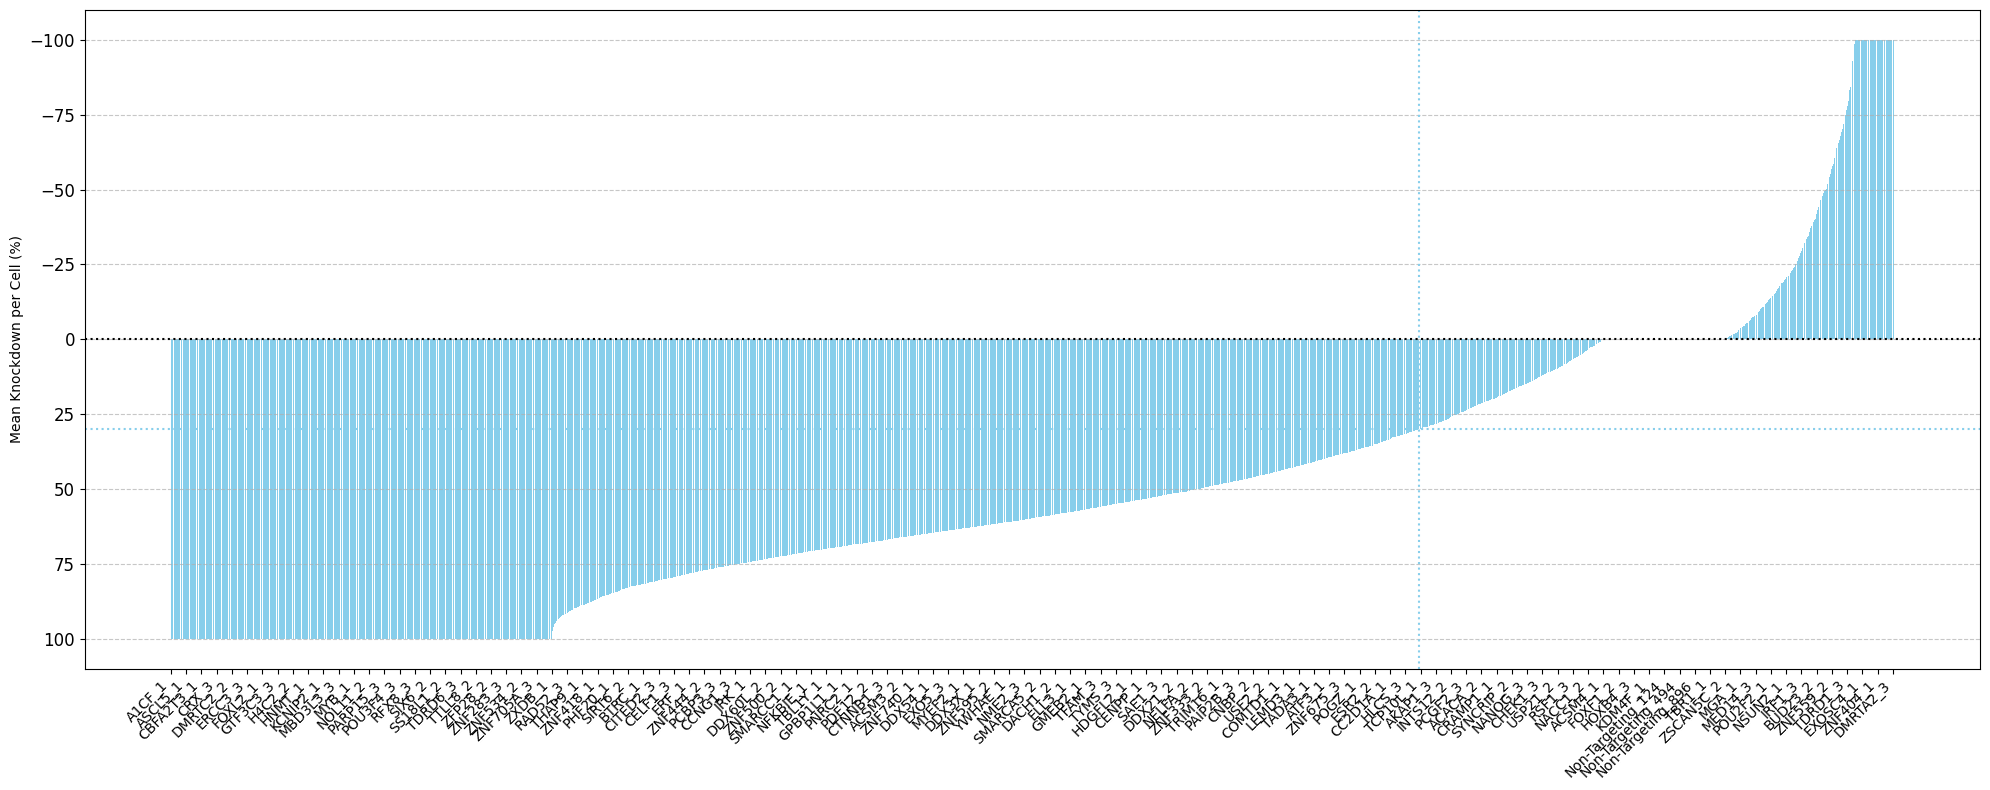

Removing 2876 perturbing sgRNA for not having more than 30% knockdown
Before filter: 11307,perturbed
True     887720
False     14108
Name: count, dtype: int64
After filter: 8431,perturbed
True     663159
False     14108
Name: count, dtype: int64
Removing 41501 perturbed cells for not having any measureable repression.
Before filter: 8431,perturbed
True     663159
False     14108
Name: count, dtype: int64
After filter: 8431,perturbed
True     621658
False     14108
Name: count, dtype: int64


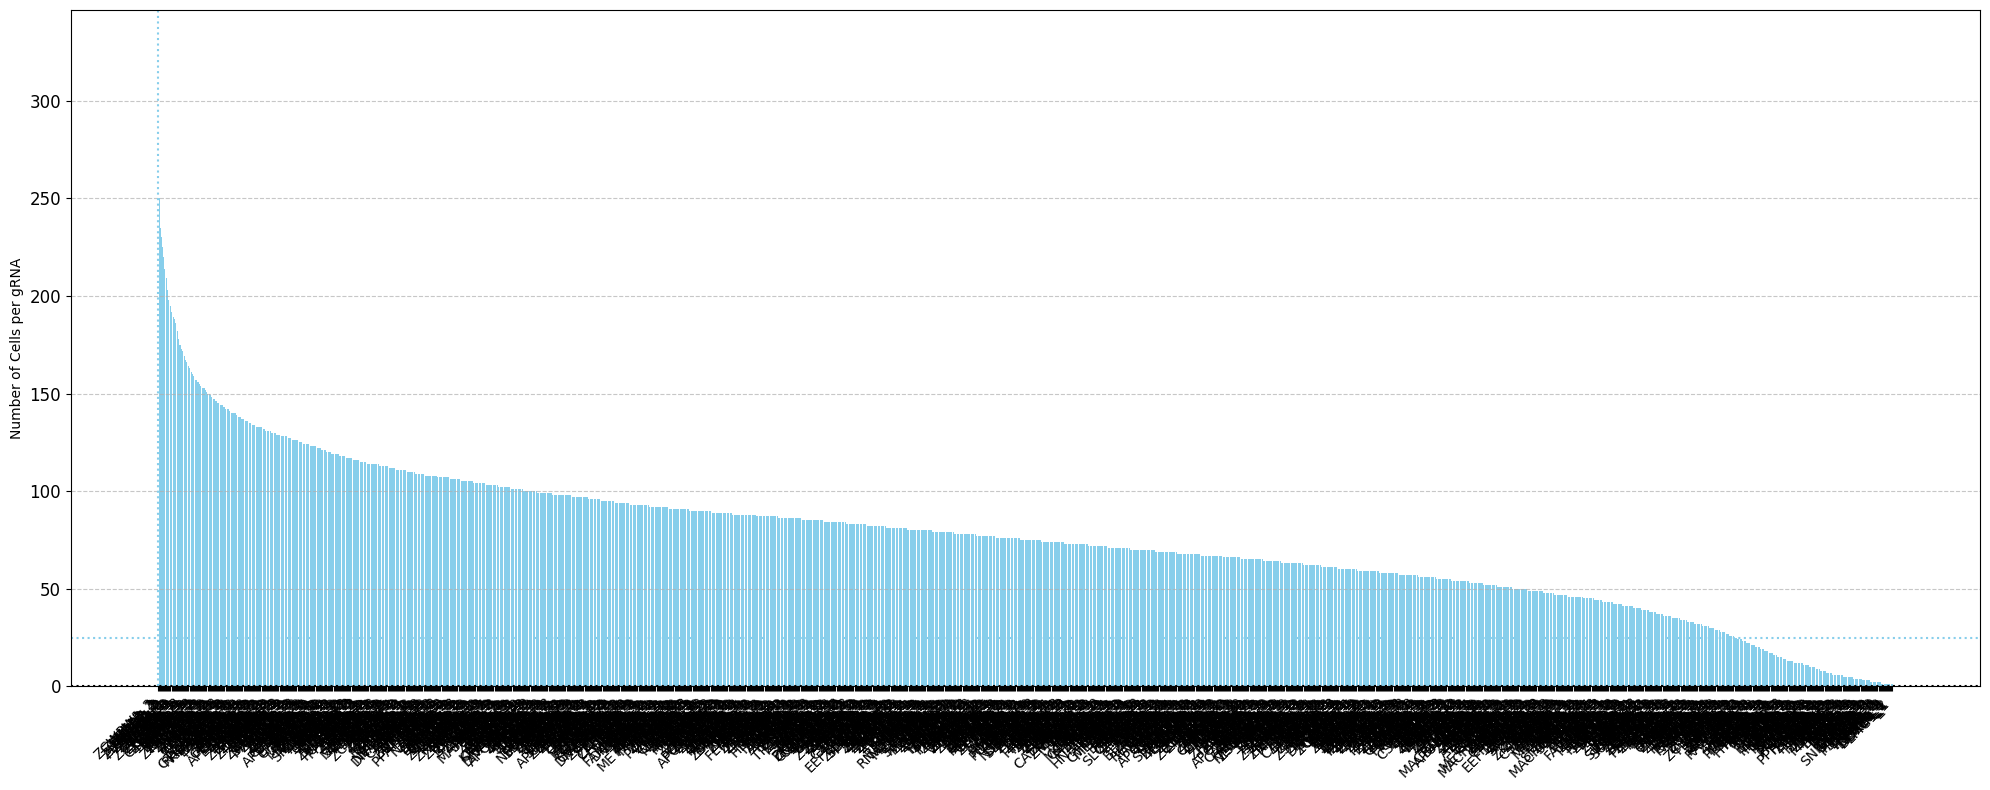

Before filter: 8431,perturbed
True     621658
False     14108
Name: count, dtype: int64
Removing 754 perturbing sgRNA for not having more than 25 cells
After filter: 7677,perturbed
True     613603
False     14108
Name: count, dtype: int64


In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA.h5ad")
knockdown_adata_alpha = qc2.knockdown_qc(adata_alpha, 'gene_target_ensembl_id', 'gene_ids').copy()

normalizing counts per cell
    finished (0:00:18)


/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


9799 out of 12155 (80.62%) non-NTC sgRNAs have more than 30% knockdown.


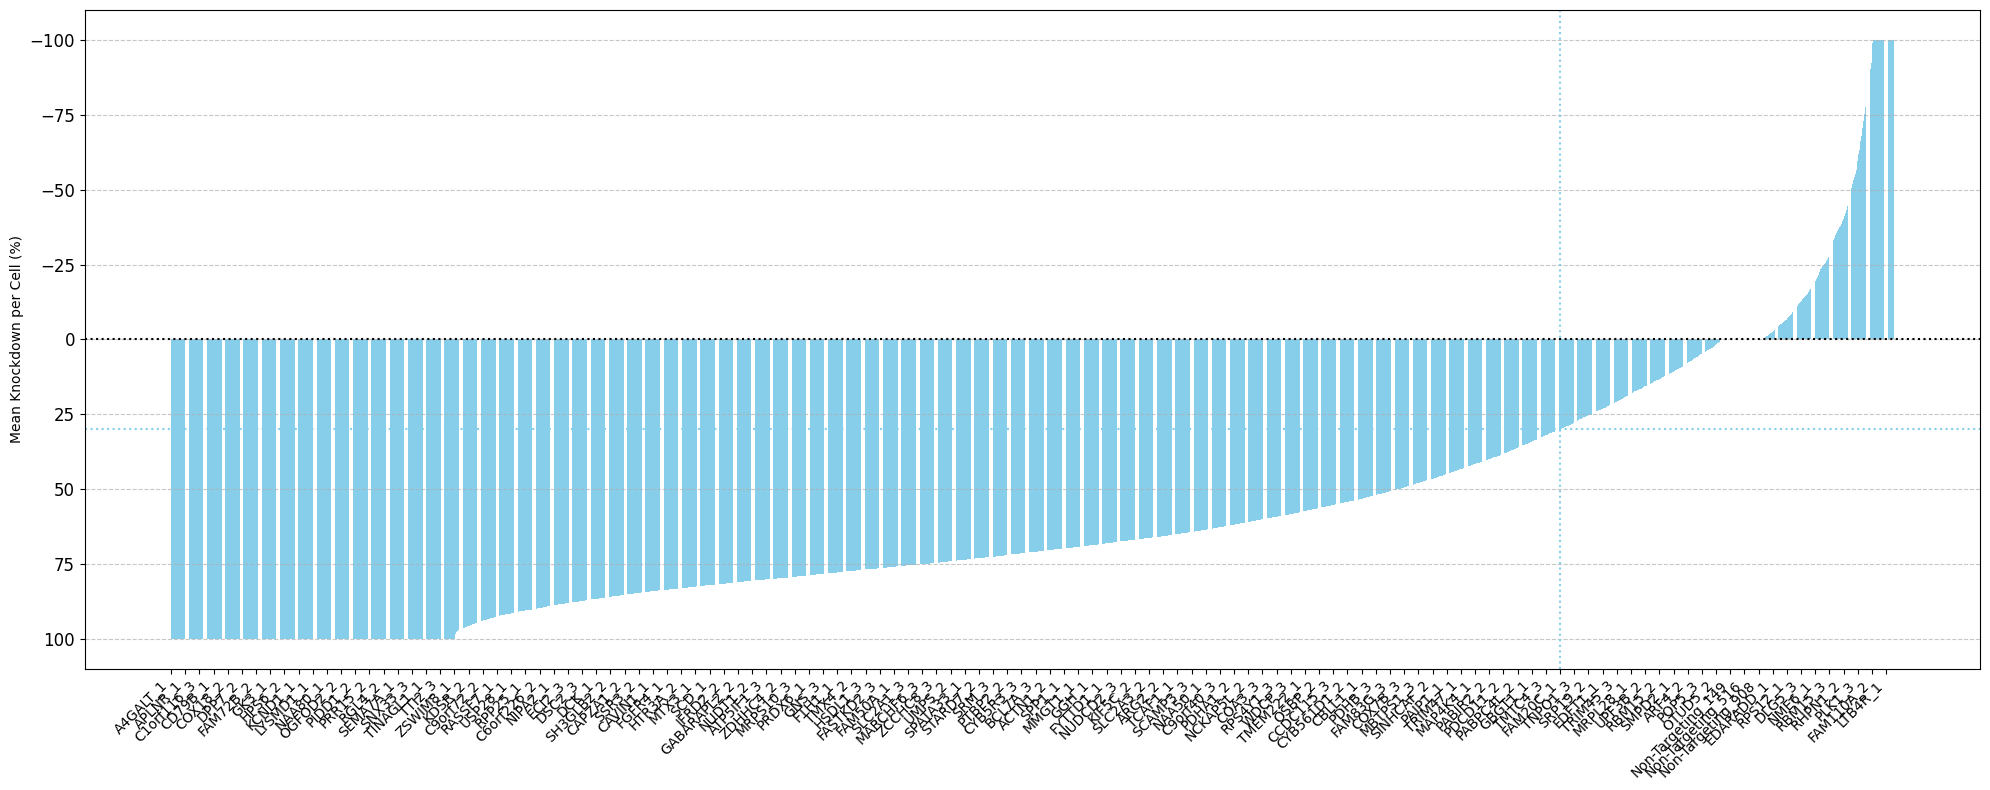

Removing 2120 perturbing sgRNA for not having more than 30% knockdown
Before filter: 12155,perturbed
True     948581
False     13537
Name: count, dtype: int64
After filter: 10035,perturbed
True     807083
False     13537
Name: count, dtype: int64
Removing 44923 perturbed cells for not having any measureable repression.
Before filter: 10035,perturbed
True     807083
False     13537
Name: count, dtype: int64
After filter: 10035,perturbed
True     762160
False     13537
Name: count, dtype: int64


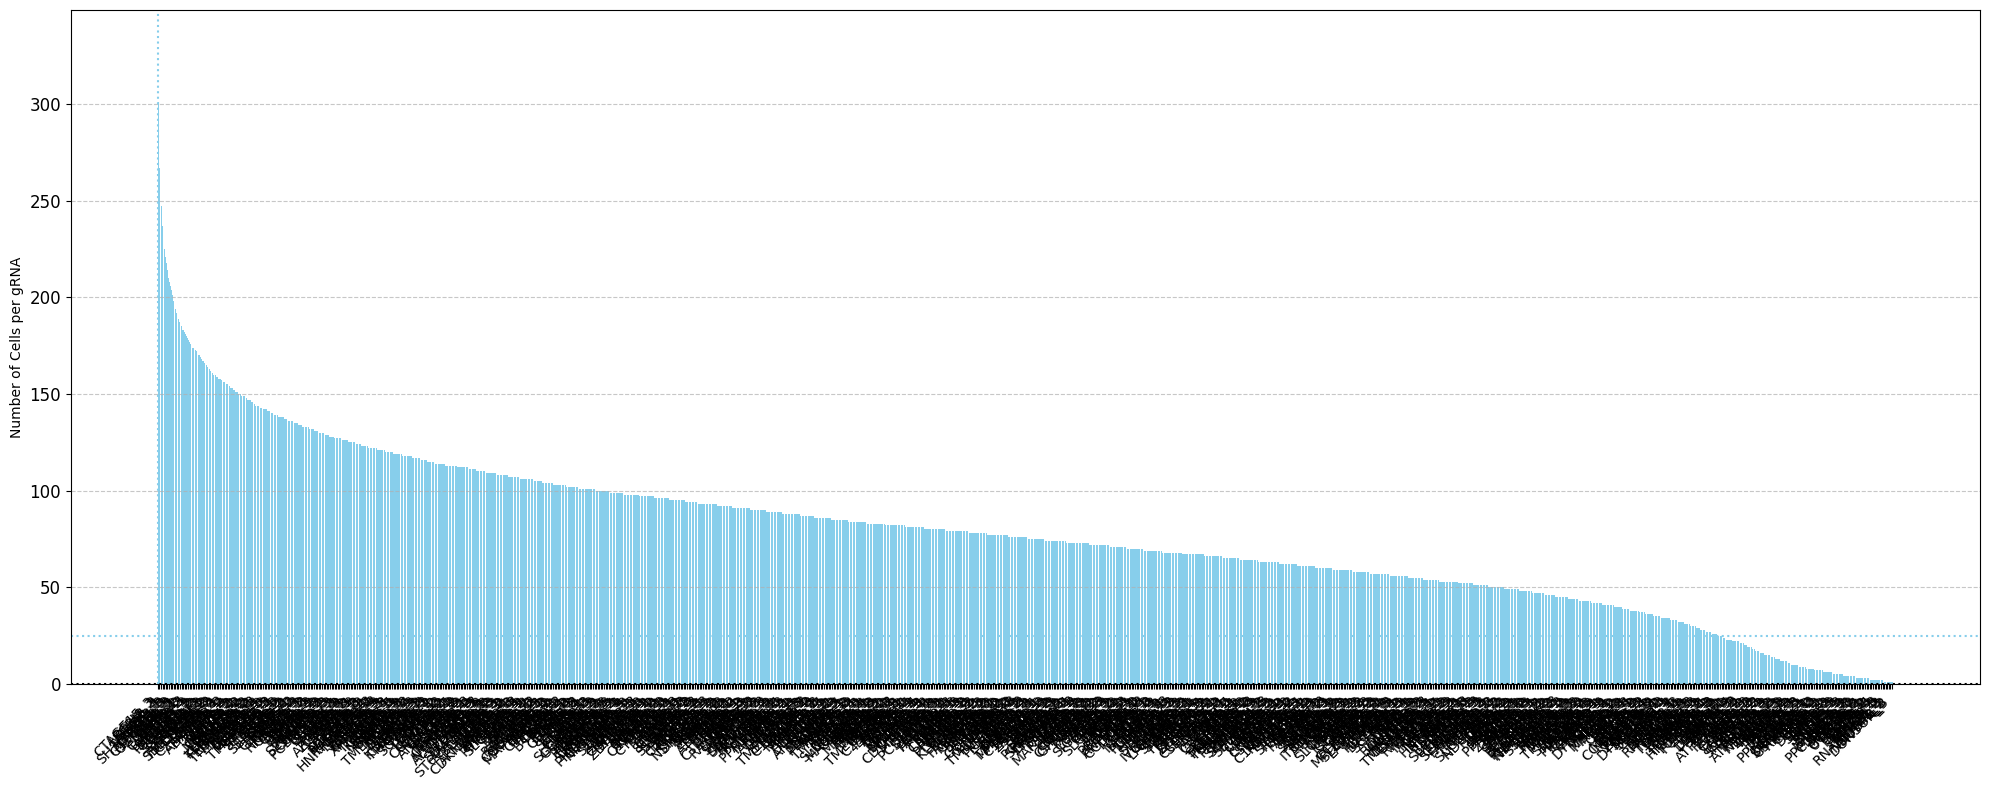

Before filter: 10035,perturbed
True     762160
False     13537
Name: count, dtype: int64
Removing 995 perturbing sgRNA for not having more than 25 cells
After filter: 9040,perturbed
True     751795
False     13537
Name: count, dtype: int64


In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA.h5ad")
knockdown_adata_beta = qc2.knockdown_qc(adata_beta, 'gene_target_ensembl_id', 'gene_ids').copy()

normalizing counts per cell
    finished (0:00:12)


/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


9888 out of 12002 (82.39%) non-NTC sgRNAs have more than 30% knockdown.


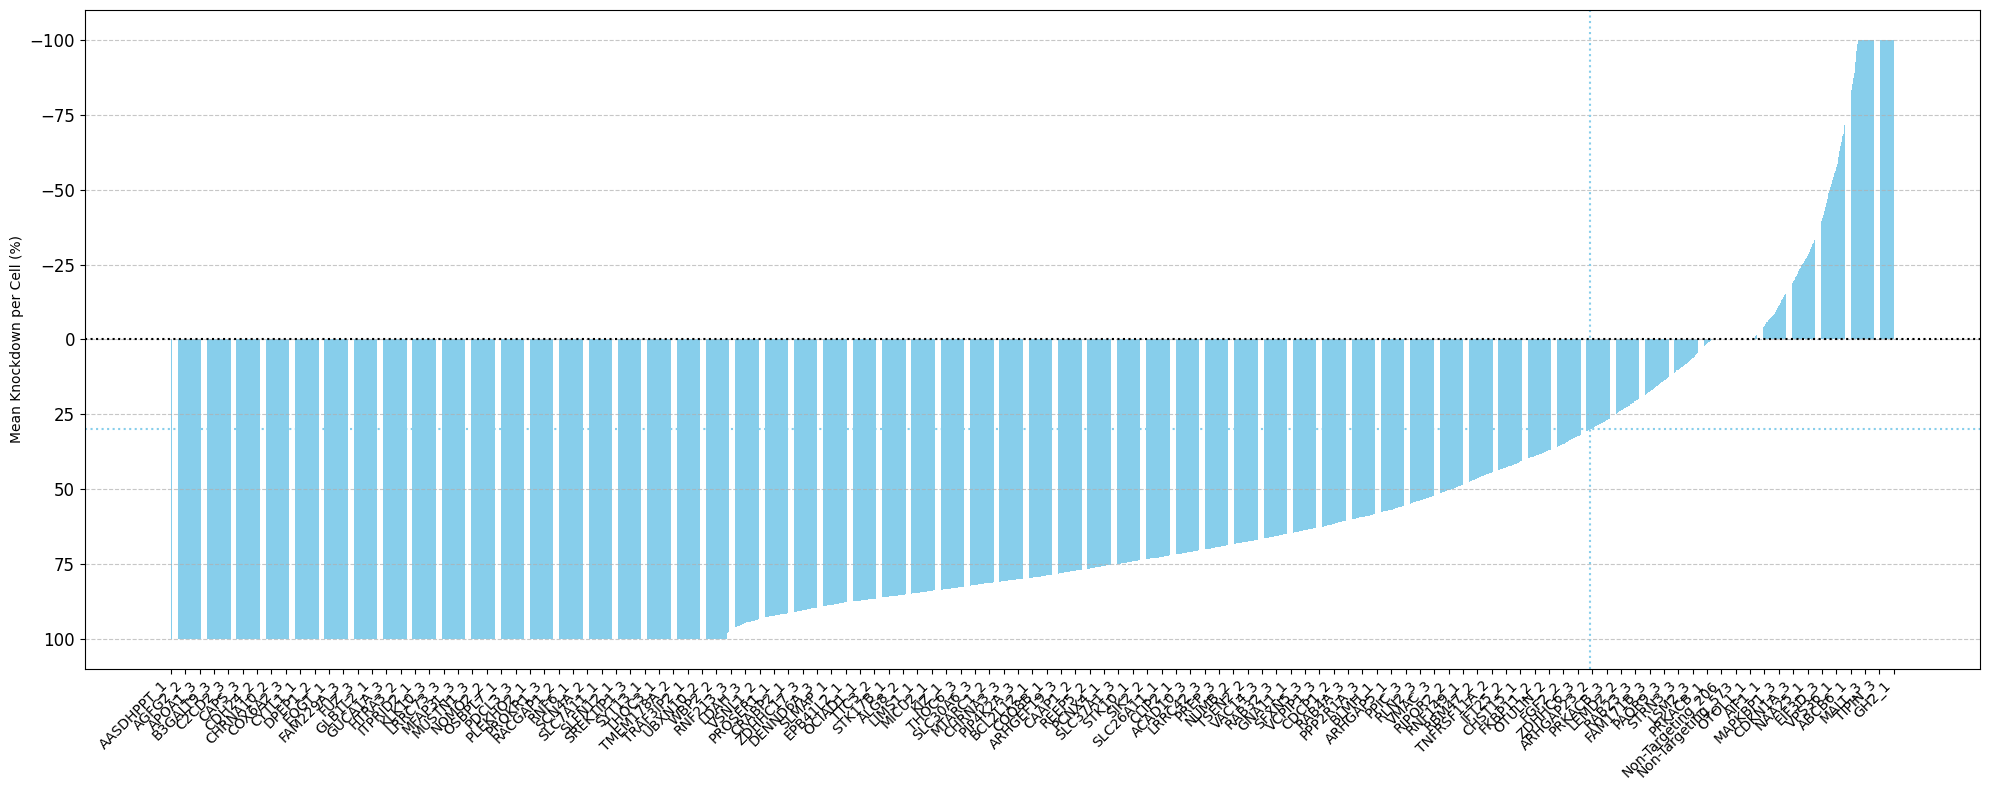

Removing 1879 perturbing sgRNA for not having more than 30% knockdown
Before filter: 12002,perturbed
True     678499
False      9788
Name: count, dtype: int64
After filter: 10123,perturbed
True     575298
False      9788
Name: count, dtype: int64
Removing 24979 perturbed cells for not having any measureable repression.
Before filter: 10123,perturbed
True     575298
False      9788
Name: count, dtype: int64
After filter: 10123,perturbed
True     550319
False      9788
Name: count, dtype: int64


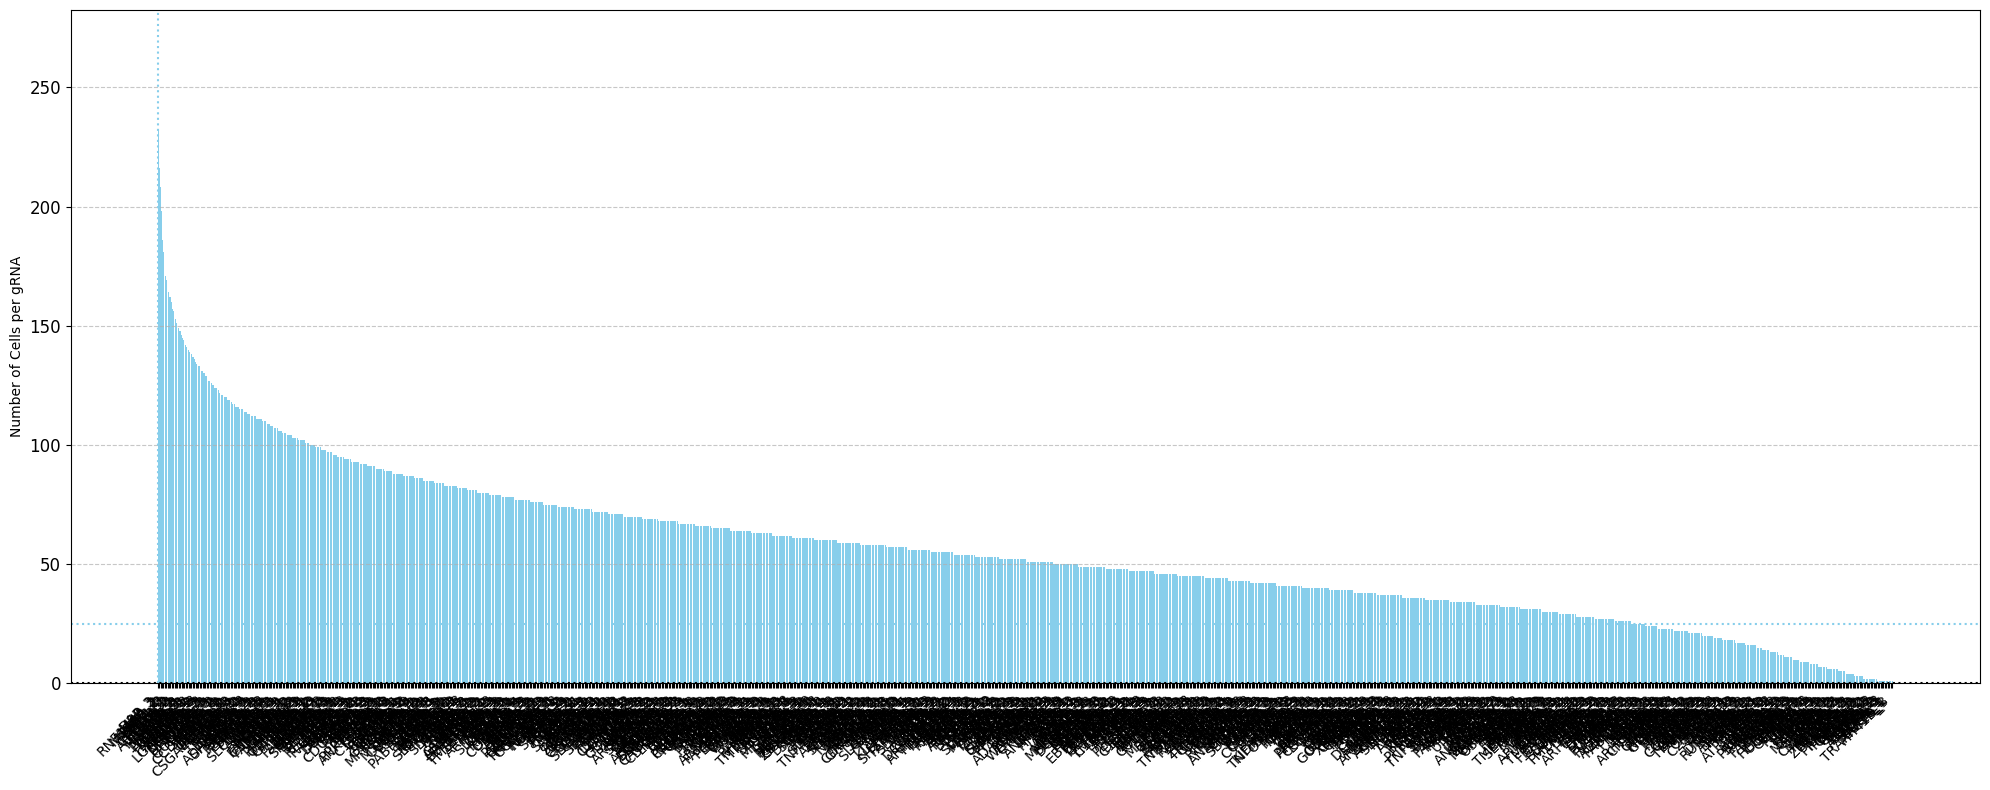

Before filter: 10123,perturbed
True     550319
False      9788
Name: count, dtype: int64
Removing 1493 perturbing sgRNA for not having more than 25 cells
After filter: 8630,perturbed
True     529985
False      9788
Name: count, dtype: int64


In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA.h5ad")
knockdown_adata_gamma = qc2.knockdown_qc(adata_gamma, 'gene_target_ensembl_id', 'gene_ids').copy()

/tmp/ipykernel_3415299/3623594956.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_3415299/3623594956.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


9530/11739 (0.8118238350796491) Perturbations achieve > 30% Knockdown


/tmp/ipykernel_3415299/3623594956.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


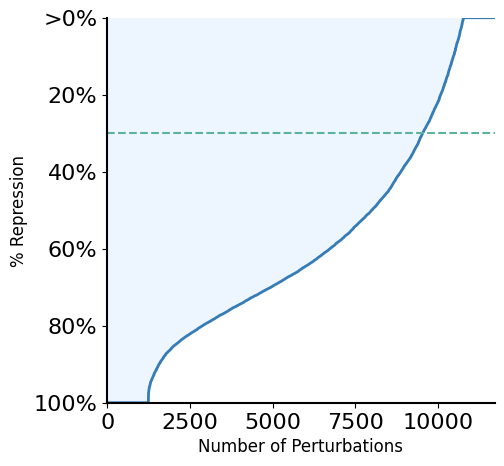

In [ ]:
alpha_knockdown = list(qc2._get_perturbed_view(adata_alpha).obs.groupby("gene_target")["target_knockdown"].mean())
beta_knockdown = list(qc2._get_perturbed_view(adata_beta).obs.groupby("gene_target")["target_knockdown"].mean())
gamma_knockdown = list(qc2._get_perturbed_view(adata_gamma).obs.groupby("gene_target")["target_knockdown"].mean())
total_knockdown = np.sort(np.clip(np.array(alpha_knockdown + beta_knockdown + gamma_knockdown),a_min=0,a_max=1))[::-1]
f = qc2.plot_percentage_perturbations_by_repression(total_knockdown)

In [ ]:
print(sum(total_knockdown > 0.3)/11739)

0.8118238350796491


Calculate median NTC number of UMI counts:

In [ ]:
median_NTC = np.median(list(qc2._get_ntc_view(knockdown_adata_alpha).obs.n_UMI_counts) 
                       + list(qc2._get_ntc_view(knockdown_adata_beta).obs.n_UMI_counts) 
                       + list(qc2._get_ntc_view(knockdown_adata_gamma).obs.n_UMI_counts))
print(median_NTC)

4542.0


In [ ]:
median_NTC = 4542.0

Normalize, log1p transform, and scale data with target sum `median_NTC`, one dataset at a time.

ALPHA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_alpha,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_alpha)
sc.pp.scale(knockdown_adata_alpha)

normalizing counts per cell
    finished (0:00:12)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_alpha.write("/home/ranwyl/data_tf_project/step_E_output_ALPHA.h5ad")

BETA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_beta,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_beta)
sc.pp.scale(knockdown_adata_beta)

normalizing counts per cell
    finished (0:00:10)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_beta.write("/home/ranwyl/data_tf_project/step_E_output_BETA.h5ad")

GAMMA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_gamma,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_gamma)
sc.pp.scale(knockdown_adata_gamma)

normalizing counts per cell
    finished (0:00:06)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_gamma.write("/home/ranwyl/data_tf_project/step_E_output_GAMMA.h5ad")

### Step F: Isolate sgRNA altering cell state and isolate perturbed cells

First we perform sgRNA level energy distance based filtering on each of the 3 data subsets.

In [ ]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

ALPHA:

In [ ]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA.h5ad")

/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:519: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:36)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)


Computing null distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/7442 [00:00<?, ?it/s]

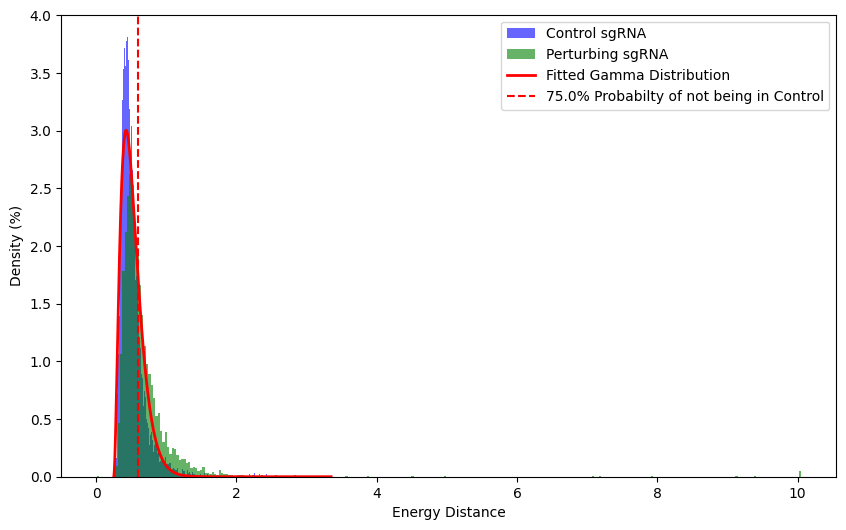

3211/7442 Perturbing sgRNA cross threshold of 0.75


In [ ]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA(knockdown_adata_alpha)

In [ ]:
alpha_filtered = alpha_filtered.copy()

In [ ]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered.h5ad")

BETA:

In [ ]:
knockdown_adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA.h5ad")

/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:519: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:10)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:42)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:45)


Computing null distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8805 [00:00<?, ?it/s]

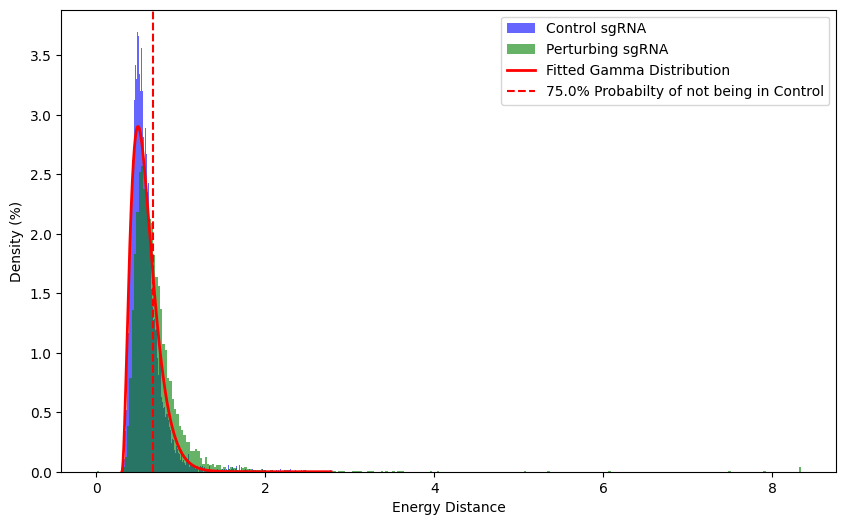

3714/8805 Perturbing sgRNA cross threshold of 0.75


In [ ]:
beta_filtered, beta_null_distances, beta_results = qc2.filter_sgRNA(knockdown_adata_beta)

In [ ]:
beta_filtered = beta_filtered.copy()

In [ ]:
beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered.h5ad")

GAMMA:

In [ ]:
knockdown_adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA.h5ad")

/home/ranwyl/data_tf_project/pan_genome_analysis_functions.py:519: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:09)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:38)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:41)


Computing null distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8396 [00:00<?, ?it/s]

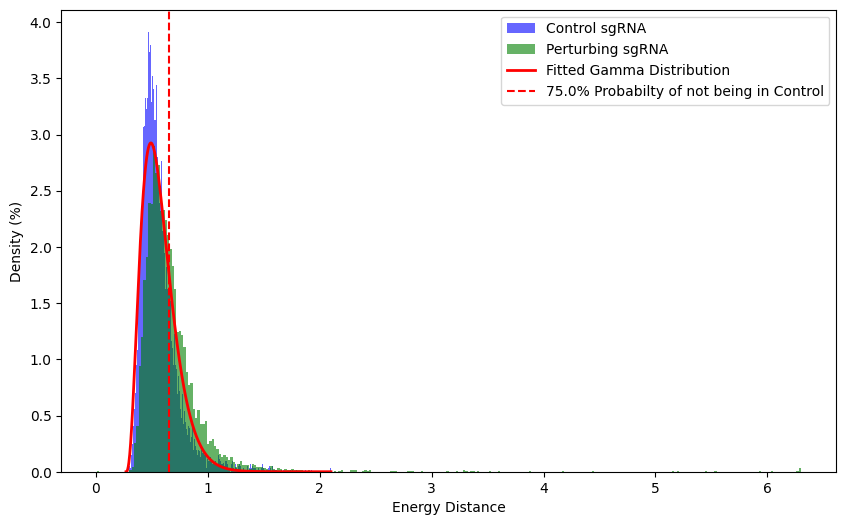

3383/8396 Perturbing sgRNA cross threshold of 0.75


In [ ]:
gamma_filtered, gamma_null_distances, gamma_results = qc2.filter_sgRNA(knockdown_adata_gamma)

In [ ]:
gamma_filtered = gamma_filtered.copy()

In [ ]:
gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered.h5ad")

Next, we remove unperturbed cells one data subset at a time.

ALPHA:

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered.h5ad")

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:03)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


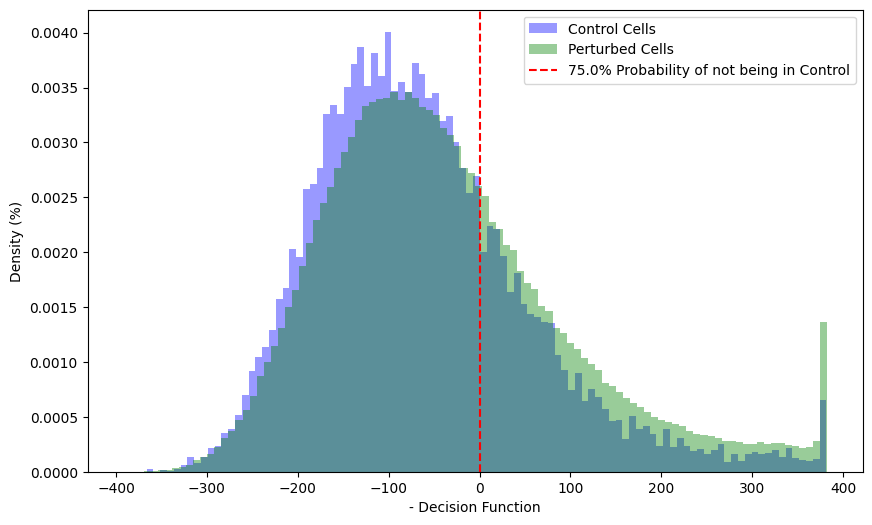

83534/258747 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells(adata_alpha, threshold=0.75)

In [ ]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1467 ['NTC', 'KAT2A', 'ZFP41', 'ARHGAP35', 'LRPPRC', 'DNMT1', 'CABIN1', 'ZNF354A', 'BHLHE40', 'EMSY', 'CHAMP1', 'EHMT1', 'PCGF1', 'PWWP2B', 'SMAD9', 'MEIS3', 'ELOC', 'HASPIN', 'PNPT1', 'HMCES', 'FOXH1', 'EZH2', 'TFAM', 'SIN3B', 'EHMT2', 'SHOX2', 'HMGB4', 'RNASEH1', 'ZBTB22', 'ALKBH1', 'METTL18', 'ZNF383', 'SMARCC1', 'ZNF521', 'SMARCE1', 'UHRF1', 'ZNF787', 'SLF1', 'DDX6', 'COMTD1', 'FOXS1', 'ACTB', 'ZNF75D', 'ETS1', 'ZNF219', 'PCGF6', 'ZFP1', 'POU5F1', 'NEK9', 'ZFP69B', 'SKP2', 'SOX4', 'NABP2', 'PDP1', 'POLRMT', 'ZNF462', 'LEMD3', 'EYA3', 'NEUROD4', 'SUZ12', 'MTA1', 'DOT1L', 'NANOG', 'ETV1', 'ESRRA', 'ZNF394', 'SLX1A', 'GATA2', 'TBX20', 'ZNF791', 'H2AC11', 'CARNMT1', 'THAP12', 'POGZ', 'ZNF419', 'TENT4B', 'ERVK3-1', 'NFIL3', 'KLF6', 'RLIM', 'FOXJ2', 'SETDB1', 'EPAS1', 'TIGD2', 'CRTC2', 'ZKSCAN1', 'H2BW2', 'KMT2D', 'FOXO3B', 'ZNF418', 'SMAD4', 'BARX1', 'PURG', 'RCOR2', 'ZNF180', 'SHOX', 'TWIST1', 'BCL6B', 'DIS3L', 'PPCS', 'MSX2', 'TRMT10C', 'E2F4', 'HES6', 'RORC', 'ZNF20', 'TP53BP1', 'BRP

In [ ]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 739 perturbations for having under 25 cells.


In [ ]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")

BETA:

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered.h5ad")

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:04)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:21)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


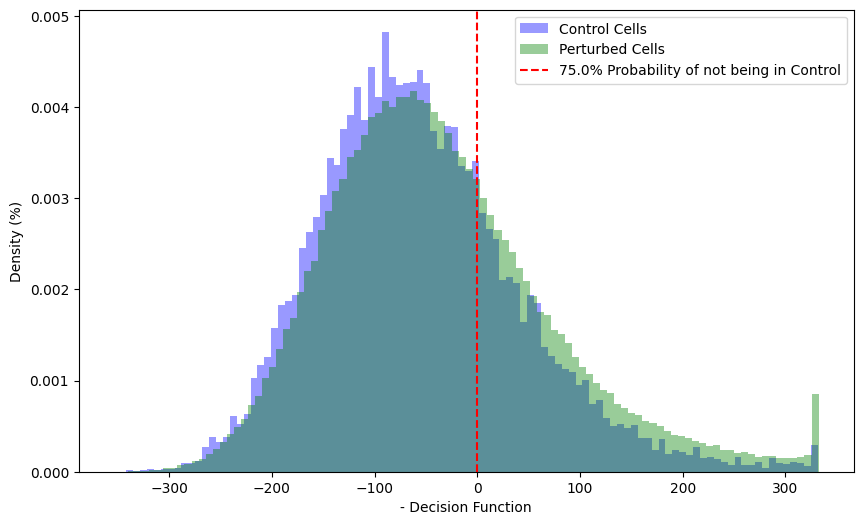

95740/306162 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells(adata_beta, threshold=0.75)

In [ ]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1696 ['NTC', 'SCAF4', 'CASP6', 'LATS2', 'BBC3', 'HCCS', 'IKBIP', 'UBFD1', 'FBXO45', 'VHL', 'JOSD1', 'VPS33A', 'UBE2M', 'RHOG', 'TESK1', 'SLC30A1', 'ETNK2', 'NAE1', 'CTAGE15', 'SGSM3', 'ACOT8', 'DSTN', 'CYCS', 'PPP1R14B', 'NCKAP5L', 'ARFRP1', 'FZD9', 'CASP3', 'IPO9', 'OSBPL2', 'BAX', 'SENP5', 'ATPAF1', 'MRPL36', 'LAMTOR1', 'YPEL3', 'TXNDC12', 'CHGA', 'LAMTOR5', 'POGLUT3', 'CLDN3', 'ACTN1', 'PACSIN1', 'CDKN2AIPNL', 'TPST2', 'MTRF1L', 'CCDC6', 'MZT2A', 'SH3BGRL3', 'ARFGAP1', 'ART5', 'C1orf159', 'CLPTM1L', 'IRAK1', 'FBXO44', 'SPRY2', 'CAPRIN2', 'CDK5R1', 'PPP1R1A', 'GRPEL2', 'IFNGR1', 'ZFPL1', 'PODXL2', 'SLC39A1', 'CAPN1', 'TWSG1', 'SLC35F6', 'FAM120AOS', 'LYSMD3', 'POLDIP2', 'DUS4L', 'TMSB4Y', 'ATAD1', 'MOSPD1', 'TCAF1', 'CLUH', 'VPS39', 'TEFM', 'FADS1', 'SLC30A5', 'KHDC4', 'MTCH1', 'SLC39A13', 'TOE1', 'VKORC1', 'GPR137', 'IFFO1', 'FJX1', 'SLC29A1', 'CAVIN1', 'LZTS2', 'FAM210B', 'WBP1', 'PTPN1', 'MRPL24', 'LIMD2', 'DPH2', 'TM6SF2', 'SNCG', 'LRCH4', 'FNDC10', 'CCDC78', 'STEAP3', 'BCKDK', '

In [ ]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 800 perturbations for having under 25 cells.


In [ ]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")

GAMMA:

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered.h5ad")

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:15)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


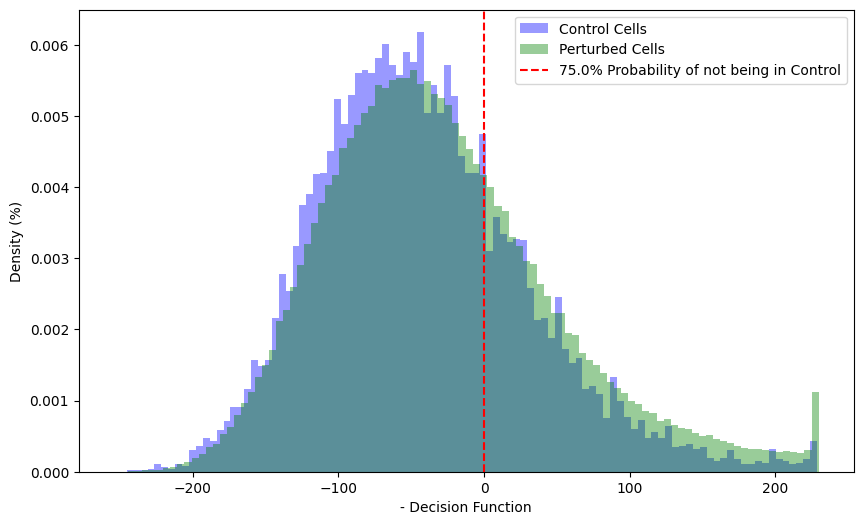

62877/205929 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells(adata_gamma, threshold=0.75)

In [ ]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1070 ['NTC', 'SUPT20H', 'FLYWCH2', 'FAM193A', 'DDT', 'RNF144A', 'NF2', 'FLCN', 'ENTPD8', 'HS2ST1', 'SCARB1', 'CNST', 'HCN2', 'RALGAPB', 'TIMM50', 'MMP16', 'CTAGE15', 'IL17RD', 'EIF4ENIF1', 'RASA2', 'WDR37', 'DRD4', 'FBXO31', 'CEP43', 'TGFBR2', 'RBM5', 'C1orf21', 'TEX2', 'STK10', 'TMEM74B', 'DENND1C', 'FAM241B', 'CRIM1', 'RAB8B', 'KLHL24', 'C3orf52', 'KCNF1', 'CEP78', 'PUS1', 'HIPK2', 'STOML1', 'RGPD5', 'PARD6G', 'PIP4P2', 'KIF17', 'NUAK2', 'MCOLN1', 'MMRN2', 'NRBP1', 'CFP', 'CACUL1', 'PDZD8', 'TBC1D7', 'AGTPBP1', 'YPEL1', 'ANXA2', 'CTAGE4', 'PAQR3', 'CLPSL2', 'ABCG1', 'PON2', 'DNAJB5', 'FAM200B', 'PEX13', 'HMCN2', 'MTPAP', 'GOLGA4', 'BTBD10', 'DTX1', 'ANXA6', 'MRRF', 'MLYCD', 'SYAP1', 'DAP', 'TBK1', 'TMEM179B', 'TRABD', 'DNAJC28', 'GRSF1', 'SLC17A7', 'FAM117B', 'SPATA25', 'UNC5B', 'LAMC3', 'CAPNS1', 'BEST4', 'BLTP3B', 'MAP4K2', 'SULF2', 'RET', 'BPGM', 'CYP2D6', 'CCDC28B', 'PCMTD1', 'GOLT1A', 'DENND4B', 'SPAG9', 'MADD', 'ANKRD17', 'CCER2', 'RNF7', 'EFNB3', 'BCL2L12', 'MAEA', 'ITPRID2', 

In [ ]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1331 perturbations for having under 25 cells.


In [ ]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

### Step G: Differential Expression Analysis

Now we will perform differential expression analysis (DEA) on a pseudobulk representation of the data and define "strong" perturbations as perturbations with >= 10 differentially expressed genes (DEGs).

Write modified Step G functions based on the study pipeline

In [3]:
def tf_run_deseq2_analysis(adata, n_jobs, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                                      n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
        )
        return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)

    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def tf_save_DEG_df(results_dict, p_threshold=0.05, save=True, filepath=None):
    # Initialize a dictionary to store columns for the final DataFrame
    final_dict = {}

    for gene_target, df in results_dict.items():
        # Filter the DataFrame based on the padj (adjusted p-value) threshold
        filtered_df = df[df['padj'] < p_threshold]

        # Sort by L2FC
        l2fc_sorted = filtered_df.sort_values('log2FoldChange')
        
        # Create columns for DEGs, L2FC, and Adj_P and add them to the final_dict
        final_dict[f'{gene_target}_DEGs'] = l2fc_sorted.index.tolist()
        final_dict[f'{gene_target}_L2FC'] = l2fc_sorted['log2FoldChange'].tolist()
        final_dict[f'{gene_target}_Adj_P'] = l2fc_sorted['padj'].tolist()

    # Group keys by gene target to maintain adjacency
    gene_targets = list(results_dict.keys())
    
    # Sort the gene targets by the number of DEGs
    sorted_gene_targets = sorted(gene_targets, key=lambda gt: len(final_dict[f'{gt}_DEGs']), reverse=True)
    
    # Reorder the final_dict to keep DEGs, L2FC, and Adj_P together for each gene target
    ordered_dict = {}
    for gene_target in sorted_gene_targets:
        ordered_dict[f'{gene_target}_DEGs'] = final_dict[f'{gene_target}_DEGs']
        ordered_dict[f'{gene_target}_L2FC'] = final_dict[f'{gene_target}_L2FC']
        ordered_dict[f'{gene_target}_Adj_P'] = final_dict[f'{gene_target}_Adj_P']

    # Find the maximum length of lists in the ordered_dict to handle unequal lengths
    max_length = max(len(lst) for lst in ordered_dict.values())

    # Pad shorter lists with None to ensure equal length columns
    for key in ordered_dict:
        ordered_dict[key].extend([None] * (max_length - len(ordered_dict[key])))

    # Create the final DataFrame directly from the dictionary
    combined_df = pd.DataFrame(ordered_dict)

    if save and filepath:
        with pd.ExcelWriter(filepath) as writer:
            combined_df.to_excel(writer, sheet_name='DEG Results', index=False)

Max RAM used for ALPHA = 573GB at 65% done. Total time ~20min to run `tf_run_deseq_2_analysis()` on 1466 genes and 1.5min to save `.xlsx` file

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha.X = adata_alpha.layers["counts"].copy()
results_dict_alpha = tf_run_deseq2_analysis(adata_alpha, 25)

In [ ]:
alpha_filepath = "/home/ranwyl/results_tf_project/ALPHA_DEGs.xlsx"
tf_save_DEG_df(results_dict_alpha, filepath=alpha_filepath)

Max RAM used for BETA = 610G at 54% done.

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_beta.X = adata_beta.layers["counts"].copy()
results_dict_beta = tf_run_deseq2_analysis(adata_beta, 27)

In [4]:
beta_filepath = "/home/ranwyl/results_tf_project/BETA_DEGs.xlsx"
tf_save_DEG_df(results_dict_beta, filepath=beta_filepath)

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")
adata_gamma.X = adata_gamma.layers["counts"].copy()
results_dict_gamma = tf_run_deseq2_analysis(adata_gamma, 30)

In [5]:
gamma_filepath = "/home/ranwyl/results_tf_project/GAMMA_DEGs.xlsx"
tf_save_DEG_df(results_dict_gamma, filepath=gamma_filepath)

Filter strong perturbations

In [5]:
alpha_degs = pd.read_excel("/home/ranwyl/results_tf_project/ALPHA_DEGs.xlsx")
beta_degs = pd.read_excel("/home/ranwyl/results_tf_project/BETA_DEGs.xlsx")
gamma_degs = pd.read_excel("/home/ranwyl/results_tf_project/GAMMA_DEGs.xlsx")

In [6]:
strong_perturbations, DEGs = qc2.create_deg_list(alpha_degs, beta_degs, gamma_degs, deg_cutoff=10)

1361 Perturbations Left at a cutoff of 10 DEGs


In [7]:
with open("/home/ranwyl/results_tf_project/strong_perturbations.txt",'w') as file:
    for item in strong_perturbations:
        file.write(f"{item}\n")

In [8]:
DEGs.to_excel("/home/ranwyl/results_tf_project/Aggregate_DEGs.xlsx")

In [8]:
strong_perturbations = list()
with open("/home/ranwyl/results_tf_project/strong_perturbations.txt") as f:
    strong_perturbations = f.read().split()
print(strong_perturbations[:5])

['POU5F1', 'MYADM', 'DBR1', 'PHF20', 'PSMD8']


In [9]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [10]:
adata_alpha_filtered = adata_alpha[adata_alpha.obs.gene_target.isin(strong_perturbations)].copy()
adata_beta_filtered = adata_beta[adata_beta.obs.gene_target.isin(strong_perturbations)].copy()
adata_gamma_filtered = adata_gamma[adata_gamma.obs.gene_target.isin(strong_perturbations)].copy()

In [11]:
del adata_alpha, adata_beta, adata_gamma
gc.collect()

3776

In [12]:
adata_combined = ad.concat([adata_alpha_filtered,adata_beta_filtered,adata_gamma_filtered])
adata_combined.X = adata_combined.layers["counts"].copy()

In [13]:
median_NTC_UMIs = np.median(qc2._get_ntc_view(adata_combined).obs.n_UMI_counts)
sc.pp.normalize_total(adata_combined, target_sum=median_NTC_UMIs)

normalizing counts per cell
    finished (0:00:00)


### Step H: Batch Correction

In [14]:
sc.pp.log1p(adata_combined)
a = adata_combined[adata_combined.obs.run == 'ALPHA'].copy()
b = adata_combined[adata_combined.obs.run == 'BETA'].copy()
c = adata_combined[adata_combined.obs.run == 'GAMMA'].copy()

In [15]:
del adata_combined
gc.collect()

1177

In [16]:
qc2.relative_z_normalization(a)

In [17]:
qc2.relative_z_normalization(b)
qc2.relative_z_normalization(c)
normalized_adata = ad.concat([a,b,c])

In [18]:
normalized_adata.write("/home/ranwyl/data_tf_project/Aggregate_Strong_Perturbations_Batch_Normalized.h5ad")

In [19]:
normalized_adata

AnnData object with n_obs × n_vars = 111902 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

# UMAPs

Variables for UMAP section of notebook

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

# DEGs from study pipeline
deg_df = pd.read_excel("/home/ranwyl/results_tf_project/Aggregate_DEGs.xlsx", index_col=0)

Helper functions and variables for UMAP section of notebook

In [3]:
def cluster_summary_df(adata, leiden_res: str):
    """
    Create DataFrame of perturbations in each Leiden cluster at the given resolution.
    """
    # Extract cluster assignments and perturbation labels
    cluster_data = adata.obs[[leiden_res, "gene_target"]]
    # Count occurrences of each perturbation in each cluster
    return cluster_data.groupby([leiden_res, "gene_target"]).size().unstack(fill_value=0)

def cluster_summary_tf_ko_df(cluster_summary_df):
    """
    Filter perturbations-per-cluster DataFrame to show only TF KOs.
    """
    return cluster_summary_df.loc[:, cluster_summary_df.columns.isin(tfs)]

def tf_ko_cluster_df(cluster_summary, n_tf_kos):
    """
    Create DataFrame of TF KOs per cluster and their occurrences.
    """
    n_clusters = cluster_summary.index.nunique()
    cluster_tf_ko_dict = dict()
    for i in range(0, n_clusters*2, 2):
        idx = int(i/2)
        freq_tf_kos = cluster_summary.iloc[idx].nlargest(n_tf_kos).index.tolist()
        tf_ko_counts = cluster_summary.iloc[idx].nlargest(n_tf_kos).tolist()
        # If there are fewer than n_tf_kos TF KOs in cluster
        nonzeros = sum(1 for x in tf_ko_counts if x != 0)
        if nonzeros != n_clusters:
            blanks = ["" for _ in range(n_tf_kos - nonzeros)]
            freq_tf_kos = freq_tf_kos[:nonzeros] + blanks
            tf_ko_counts = tf_ko_counts[:nonzeros] + blanks
        cluster_tf_ko_dict[i] = freq_tf_kos
        cluster_tf_ko_dict[i+1] = tf_ko_counts
    cluster_tf_kos = pd.DataFrame.from_dict(cluster_tf_ko_dict)
    # Add header rows
    header1 = [f"cluster {int(i/2)}" if i % 2 == 0 else "" for i in range(n_clusters*2)]
    header2 = ["TF KO", "count"]*n_clusters
    cluster_tf_kos.columns = pd.MultiIndex.from_tuples(list(zip(header1, header2)))
    return cluster_tf_kos

def tf_ko_cluster_df_from_adata(adata, leiden_res: str, n_tf_kos):
    """
    Given an AnnData object, a Leiden clustering resolution, and a number of TF KOs to display per cluster,
    create a DataFrame of TF KOs per cluster and their occurrences.
    """
    return tf_ko_cluster_df(cluster_summary_tf_ko_df(cluster_summary_df(adata, leiden_res)), n_tf_kos)

def tf_ko_only_cluster_df(cluster_tf_ko_df):
    """
    Filter DataFrame of TF KOs per cluster and their occurrences to show only TF KOs per cluster without counts.
    """
    cluster_tf_kos = cluster_tf_ko_df.copy()
    new_header = cluster_tf_kos.columns.values.tolist()
    new_header = [new_header[i][0] for i in range(len(new_header))]
    cluster_tf_kos = cluster_tf_kos.set_axis(new_header, axis=1)
    cluster_tf_kos = cluster_tf_kos.loc[:, cluster_tf_kos.columns != ""].copy()
    return cluster_tf_kos

## UMAP of all strong perturbations, no LFC filter for DEGs

Now we want to visualize the UMAP embedding of the QC-passed dataset to see which KOs cluster together.

In [4]:
adata = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Strong_Perturbations_Batch_Normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 111902 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

The preprocessing steps of normalization (in this case, to the median UMI count of NTC cells) and log1p transformation have already been performed. The data has also been z-normalized as part of batch correction, so scaling does not need to be performed. We will perform feature selection using a pipeline function that implements batch-aware highly variable gene (HVG) selection. This function takes an `AnnData` object and a `DataFrame` of DEGs and returns a subset of the input `AnnData` object containing only the HVGs. By default, the function considers the top 20 upregulated and top 20 downregulated DEGs for each perturbation, and finds 2000 additional HVGs with the `scanpy` `highly_variable_genes` method.

In [7]:
adata = qc2.create_HVG_set_top_n_degs(adata, deg_df)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Constructing a set of 5017 unique HVGs from 3521 unique DEGs and 2000 unique HVGs


In [8]:
adata

AnnData object with n_obs × n_vars = 111902 × 5017
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

View and save the perturbation-associated DEGs:

In [9]:
pert_assoc_degs = adata.var.index.tolist()
print(len(pert_assoc_degs))
print(pert_assoc_degs[:10])

5017
['PUSL1', 'AURKAIP1', 'CCNL2', 'MRPL20', 'SSU72', 'GNB1', 'CFAP74', 'SKI', 'HES5', 'ENSG00000272235']


In [10]:
with open("/home/ranwyl/results_tf_project/perturbation_associated_DEGs.txt", "w") as f:
    for deg in pert_assoc_degs:
        f.write(f"{deg}\n")

Now we will perform PCA and visualize the elbow plot to determine how many PCs to use for k-nearest neighbors computation.

computing PCA
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


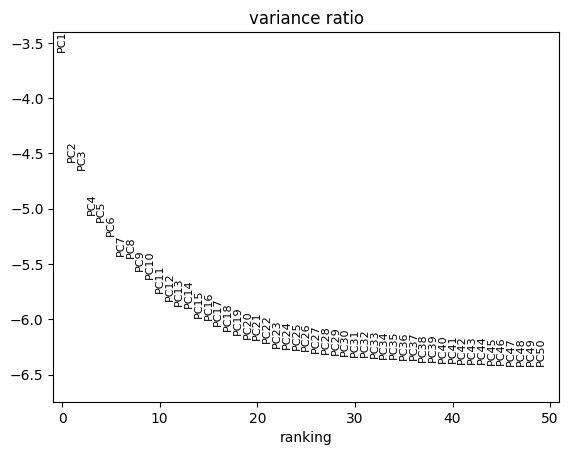

In [10]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True) #Elbow plot

Based on the elbow plot, we will use the first 30 PCs to compute the neighborhood. Now we will compute k-nearest neighbors and embed the neighborhood graph in two dimensions for UMAP visualization.

In [11]:
num_pcs = 30 # Change this to desired number of principal components
sc.pp.neighbors(adata, n_pcs=num_pcs)
sc.tl.umap(adata)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:31)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:09)


We will perform Leiden clustering at 3 different resolutions and see how many clusters there are at each resolution. We are targeting about 10 clusters total.

In [12]:
for res in [0.5, 0.75, 1]:
    sc.tl.leiden(adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res_0.75', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:03)


Visualize the UMAP for each resolution:

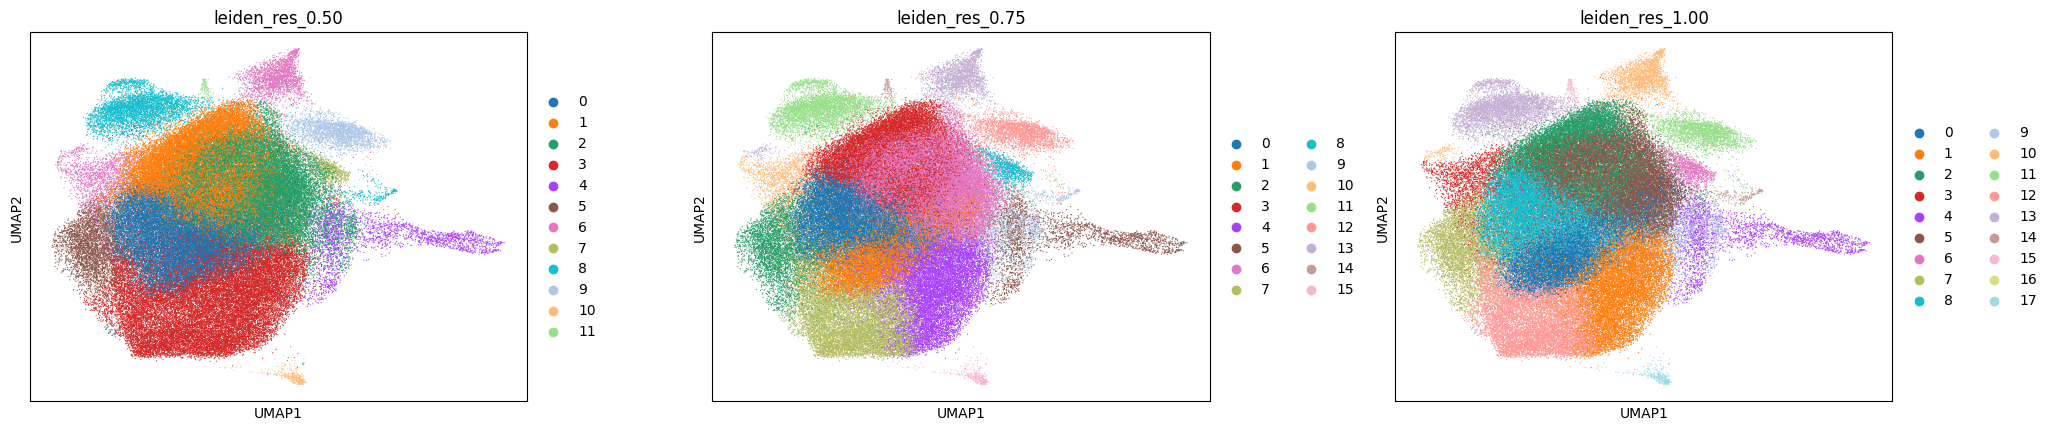

In [11]:
sc.pl.umap(adata, color=["leiden_res_0.50", "leiden_res_0.75", "leiden_res_1.00"], wspace=0.25, size=3)

We will also perform Leiden clustering with lower resolutions of 0.40 and 0.45 and see how many clusters there are.

In [13]:
for res in [0.40, 0.45]:
    sc.tl.leiden(adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res_0.40', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0.45', the cluster labels (adata.obs, categorical) (0:00:03)


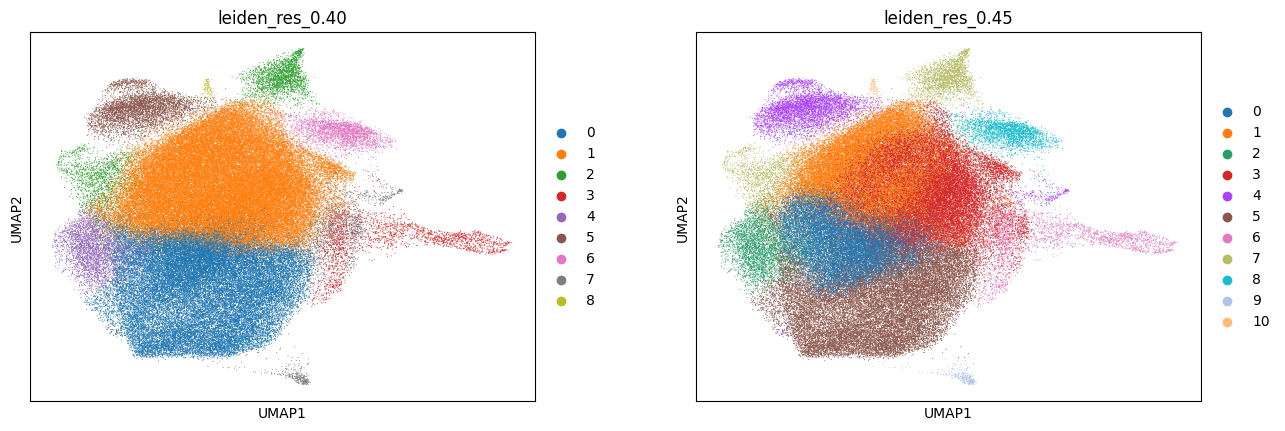

In [26]:
sc.pl.umap(adata, color=["leiden_res_0.40", "leiden_res_0.45"], wspace=0.2, size=2)

In [60]:
cluster_data = adata.obs[["leiden_res_0.50", "gene_target"]]
# Count occurrences of each perturbation in each cluster
cluster_data.groupby(["leiden_res_0.50", "gene_target"]).size().unstack(fill_value=0)

gene_target      AAAS  ABCD4  ABCF1  ABHD17A  ABI2  ACBD4  ACCS  ACIN1  ACLY  \
leiden_res_0.50                                                                
0                   9      3      6        5     8      4     3      4     4   
1                  12     10      6        9     7      5     6      5    10   
2                  18     19     13       11    17     11     7      9     9   
3                  20     13      2        6     7      9     6      9     5   
4                   2      0      0        3     0      0     1      1     1   
5                   5      3      0        1     1      0     1      0     4   
6                   3      3      3        3     3      0     3      0     3   
7                   0      0      0        0     0      0     0      0     0   
8                   1      3      0        0     2      3     4      2     1   
9                   2      2      0        1     3      1     0      0     2   
10                  0      0      0        0     0      0     0      0     0   
11                  0      0      0        0     0      0     0      0     0   

gene_target      ACOT8  ...  ZNF780A  ZNF783  ZNF823  ZNF844  ZNF888  ZNRF1  \
leiden_res_0.50         ...                                                   
0                    8  ...        5       4       5       9       4      3   
1                   27  ...       10      10      14      28      12      5   
2                   36  ...        2       7       5      20       8      6   
3                   22  ...        5      11       5      10       7     10   
4                    3  ...        1       0       1       1       1      1   
5                    9  ...        3       0       0       1       1      1   
6                    5  ...        1       3       0       2       3      1   
7                    1  ...        0       0       0       0       0      0   
8                    1  ...        4       1       1       4       1      2   
9                    5  ...        2       1       0       3       1      1   
10                   0  ...        0       0       0       0       0      0   
11                   0  ...        0       0       0       0       0      0   

gene_target      ZSCAN18  ZSCAN25  ZSCAN32  ZYX  
leiden_res_0.50                                  
0                     10        3        6    4  
1                     23        9       17    7  
2                      6        4        3    8  
3                      9        7        9    4  
4                      1        0        1    0  
5                      4        2        1    4  
6                      1        1        2    2  
7                      1        0        0    0  
8                      3        0        2    3  
9                      0        1        1    1  
10                     1        0        1    0  
11                     0        0        0    0  

[12 rows x 1354 columns]

We will continue with the UMAP with 12 clusters (Leiden clustering resolution 0.5) and see if the number of unique TF KOs per cluster is reasonable. Now we want to see which perturbations cluster together.

In [56]:
cluster_summary_05 = cluster_summary_df(adata, "leiden_res_0.50")
cluster_summary_05.head()

gene_target      AAAS  ABCD4  ABCF1  ABHD17A  ABI2  ACBD4  ACCS  ACIN1  ACLY  \
leiden_res_0.50                                                                
0                   9      3      6        5     8      4     3      4     4   
1                  12     10      6        9     7      5     6      5    10   
2                  18     19     13       11    17     11     7      9     9   
3                  20     13      2        6     7      9     6      9     5   
4                   2      0      0        3     0      0     1      1     1   

gene_target      ACOT8  ...  ZNF780A  ZNF783  ZNF823  ZNF844  ZNF888  ZNRF1  \
leiden_res_0.50         ...                                                   
0                    8  ...        5       4       5       9       4      3   
1                   27  ...       10      10      14      28      12      5   
2                   36  ...        2       7       5      20       8      6   
3                   22  ...        5      11       5      10       7     10   
4                    3  ...        1       0       1       1       1      1   

gene_target      ZSCAN18  ZSCAN25  ZSCAN32  ZYX  
leiden_res_0.50                                  
0                     10        3        6    4  
1                     23        9       17    7  
2                      6        4        3    8  
3                      9        7        9    4  
4                      1        0        1    0  

[5 rows x 1354 columns]

Generate a DataFrame with the number of occurrences of each TF KO in each cluster.

In [115]:
cluster_05_cluster_by_tf_ko = cluster_summary_tf_ko_df(cluster_summary_05)
cluster_05_cluster_by_tf_ko

gene_target      AKAP8L  ANKZF1  ARHGAP35  ASCL5  ASH1L  ATMIN  ATOH1  BARHL1  \
leiden_res_0.50                                                                 
0                     6       6        25      6      4      2     10       8   
1                     6      14        49     20     17      8     20      13   
2                    15       5        23      6      5      7     11      10   
3                     8       4        47      9     15      6     15      12   
4                     1       1         3      1      0      0      3       0   
5                     3       1         8      0      0      1      4       1   
6                     2       5        12      4      1      2      4       2   
7                     2       0         4      0      0      0      0       1   
8                     1       3         8      0      4      2      4       1   
9                     1       1         3      2      1      2      4       5   
10                    0       0         4      0      0      0      0       2   
11                    0       0         0      0      0      1      0       0   

gene_target      BARX1  BHLHA9  ...  ZNF732  ZNF735  ZNF780A  ZNF783  ZNF823  \
leiden_res_0.50                 ...                                            
0                   10       9  ...       4       5        5       4       5   
1                   22      25  ...      18       8       10      10      14   
2                   16      12  ...       5       7        2       7       5   
3                   16      19  ...       7      12        5      11       5   
4                    1       1  ...       0       0        1       0       1   
5                    0       1  ...       0       0        3       0       0   
6                    8       1  ...       5       6        1       3       0   
7                    2       1  ...       0       0        0       0       0   
8                    4       8  ...       1       2        4       1       1   
9                    5       2  ...       2       2        2       1       0   
10                   0       0  ...       0       0        0       0       0   
11                   0       0  ...       0       0        0       0       0   

gene_target      ZNF844  ZNF888  ZSCAN18  ZSCAN25  ZSCAN32  
leiden_res_0.50                                             
0                     9       4       10        3        6  
1                    28      12       23        9       17  
2                    20       8        6        4        3  
3                    10       7        9        7        9  
4                     1       1        1        0        1  
5                     1       1        4        2        1  
6                     2       3        1        1        2  
7                     0       0        1        0        0  
8                     4       1        3        0        2  
9                     3       1        0        1        1  
10                    0       0        1        0        1  
11                    0       0        0        0        0  

[12 rows x 229 columns]

In [205]:
cluster_05_cluster_by_tf_ko.columns[1]

'ANKZF1'

Now we want to find which TF KOs occur most frequently in each cluster. First, we will create a DataFrame with the 20 most frequent TF KOs per cluster and the number of occurrences of each TF KO.

In [41]:
num_tf_kos_per_cluster = 20
cluster_05_tf_kos_counts_df = tf_ko_cluster_df(cluster_05_cluster_by_tf_ko, num_tf_kos_per_cluster)
cluster_05_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      ZFP41    28    CHAMP1    54     ZFP41    52  ARHGAP35    47    POU5F1   
1   ARHGAP35    25     ZFP41    53     FOXH1    26     ZFP41    42    ZNF521   
2      FOXH1    24  ARHGAP35    49  ARHGAP35    23   ZNF354A    40     PHF20   
3    ZNF354A    21   ZNF354A    41     NANOG    23     SHOX2    30    POU3F2   
4     ZNF205    19    ZNF462    39   MSANTD4    22      ETS1    29   POU5F1B   
5     CHAMP1    18     NFIL3    37    ZNF75D    21     DOT1L    28    ZNF396   
6     ZBTB22    18      ETS1    33    ZNF844    20      SHOX    27    HOXD13   
7    NEUROD4    17      HES6    33      ZFP1    19     FOXJ2    26     NANOG   
8     ZFP69B    17     SHOX2    32     FOXS1    18     PCGF6    26    PRDM14   
9       ETV1    16      SOX4    32   ZNF354A    18    ZNF383    26      PURG   
10      PURG    16   NEUROD4    31    ZNF383    18      E2F4    25   NANOGP8   
11      SOX4    16    ZNF219    31      PURG    17    ZBTB22    25      RBPJ   
12     FOXS1    15     TBX20    30    THAP12    17    ZFP69B    25    ZNF418   
13      ZFP1    15    ZFP69B    30    ZBTB22    17    ZNF219    24    SETDB2   
14    ZNF219    15    ZNF394    30     ZFP30    17    CHAMP1    23      ESR1   
15      MTF2    14     TBX18    29     BARX1    16    ZNF75D    23   NEUROD4   
16    SETDB1    14     TIGD2    29      ESR1    16      SOX4    22     TIGD2   
17     TBX20    14      ZFP1    29     FOXK2    16    ZNF420    22    ZNF75D   
18     PITX3    13     PCGF6    28     PCGF6    16    MTERF4    21    ZNF701   
19     SHOX2    13    ZBTB22    28     SHOX2    16    SETDB1    21     ESRRA   

          ... cluster 7       cluster 8       cluster 9       cluster 10  \
   count  ...     TF KO count     TF KO count     TF KO count      TF KO   
0     93  ...  ARHGAP35     4     SALL4    13       DR1     6   ARHGAP35   
1     58  ...     PCGF6     3     THAP6    11      E2F4     6     CHAMP1   
2     45  ...     ZFP41     3     ESRRA     9     ZFP41     6      NFIL3   
3     44  ...    AKAP8L     2      MAFG     9    ZNF420     6     BARHL1   
4     44  ...     BARX1     2  ARHGAP35     8    BARHL1     5      DMRT2   
5     39  ...      FOSB     2    BHLHA9     8     BARX1     5       EBF2   
6     35  ...     FOXJ2     2     FOXS1     8     PCGF6     5       ESR1   
7     23  ...    ZBTB42     2     SNAI1     8     PITX3     5    FOXD4L5   
8     15  ...    ZNF462     2      PHF1     7      SOX4     5      FOXE3   
9      9  ...    ZNF573     2     SMAD4     7     TIGD2     5      FOXK1   
10     7  ...    BARHL1     1     TBX20     7    ZNF383     5      FOXS1   
11     7  ...    BHLHA9     1     ZFP41     7    ZNF462     5       HES6   
12     7  ...      CBX2     1   ZNF354A     7     ATOH1     4     PRDM12   
13     6  ...    CREBL2     1    ZNF418     7      ETV1     4      TCF12   
14     5  ...      CREM     1      HES7     6     FOXJ2     4      TIGD6   
15     5  ...     DMRT2     1      JRKL     6     GATA5     4     ZBTB22   
16     5  ...     DNMT1     1    MTERF3     6     NANOG     4      ZFP30   
17     5  ...      DUXA     1   NEUROD4     6     PRDM8     4      ZFP41   
18     5  ...      ETS1     1    NKX2-4     6      PURG     4     ZNF75D   
19     4  ...     FOXK2     1    POU2F1     6    ZNF219     4    ZNF354A   

         cluster 11        
   count      TF KO count  
0      4      DNMT1   113  
1      4     SETDB1    11  
2      3     CHAMP1    10  
3      2      PITX3     4  
4      2        VDR     4  
5      2      ATMIN     1  
6      2      DOT1L     1  
7      2       ETS2     1  
8      2      FOXJ2     1  
9      2       TCF3     1  
10     2      TIGD2     1  
11     2      TIGD6     1  
12     2     ZNF706     1  
13     2                   
14     2                   
15     2                   
16     2                   
17     2                   
18     2 

We want to visualize this data in an informative way so that we can decide which Leiden clustering resolution is optimal. First, we will graph the pivot table version of the data:

In [246]:
def sns_stacked_bar_lines(pivot_df, legend=True):
    # Create the figure and axes
    if legend:
        _, ax = plt.subplots(figsize=(20, 10))
    else:
        _, ax = plt.subplots(figsize=(10, 5))

    # Plot each cluster as a group of vertical bars
    bar_width = 0.8  # Bar width
    spacing = 0.1  # Spacing between vertical bars

    # Loop through each cluster and plot the vertical bars for each TF KO
    for i, cluster in enumerate(pivot_df.index):
        # Initialize the bottom of the bars (start from 0 for each cluster)
        bottom = 0
        for j, tf_ko in enumerate(pivot_df.columns):
            count = pivot_df.loc[cluster, tf_ko]
            
            if count > 0:  # Only plot TF KOs that have at least 1 cell in the cluster
                ax.bar(x=i, height=count, width=bar_width, bottom=bottom, label=tf_ko if i == 0 else "", 
                    edgecolor="white", linewidth=0.2)
                bottom += count + spacing  # Update the bottom to stack the next bar

    # Customize the plot
    ax.set_title("TF KO Counts in Each Cluster", fontsize=14)
    ax.set_ylabel("Number of Cells", fontsize=12)
    ax.set_xlabel("Cluster", fontsize=12)
    ax.set_xticks(np.arange(len(pivot_df.index)))
    ax.set_xticklabels(pivot_df.index, fontsize=10)
    if legend:
        ax.legend(title="TF KO", bbox_to_anchor=(1, 1), ncols=5)

    plt.tight_layout()  # To ensure everything fits within the plot area
    plt.show()

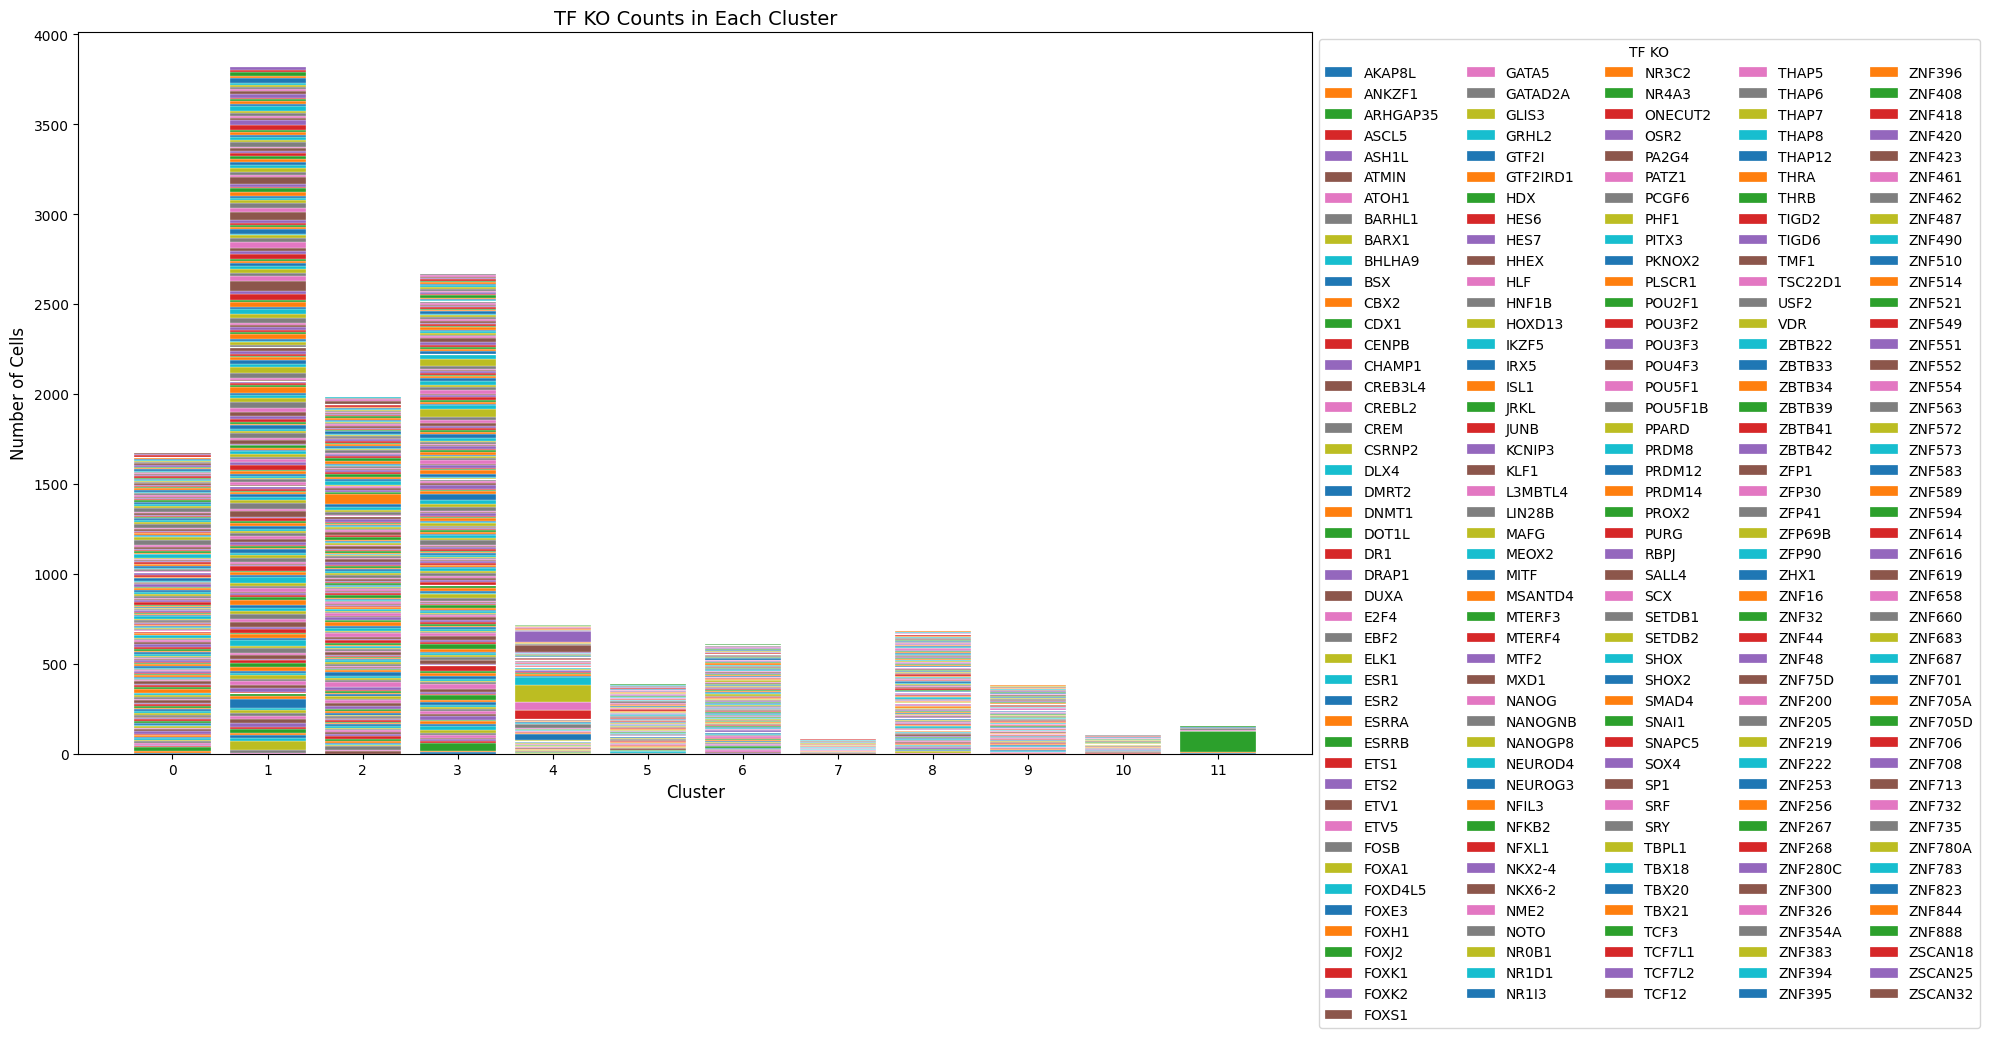

In [247]:
sns_stacked_bar_lines(cluster_05_cluster_by_tf_ko)

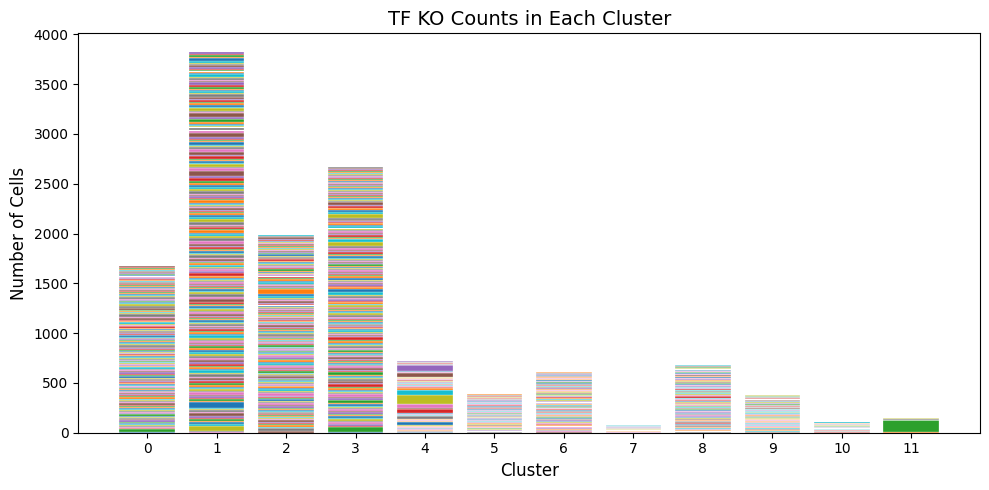

In [248]:
sns_stacked_bar_lines(cluster_05_cluster_by_tf_ko, legend=False)

^ That one is my favorite, but we will try some more

In [243]:
def sns_heatmap(df_pivot):
    sns.heatmap(df_pivot, cmap="Blues", annot=False, fmt="d", linewidths=0.5)
    plt.xlabel("Cluster")
    plt.ylabel("TF KO")
    plt.title("TF KO Distribution Across Clusters")
    plt.show()

In [116]:
cluster_summary_05_tf_ko_by_cluster = cluster_05_cluster_by_tf_ko.T
cluster_summary_05_tf_ko_by_cluster.head()

leiden_res_0.50   0   1   2   3  4  5   6  7  8  9  10  11
gene_target                                               
AKAP8L            6   6  15   8  1  3   2  2  1  1   0   0
ANKZF1            6  14   5   4  1  1   5  0  3  1   0   0
ARHGAP35         25  49  23  47  3  8  12  4  8  3   4   0
ASCL5             6  20   6   9  1  0   4  0  0  2   0   0
ASH1L             4  17   5  15  0  0   1  0  4  1   0   0

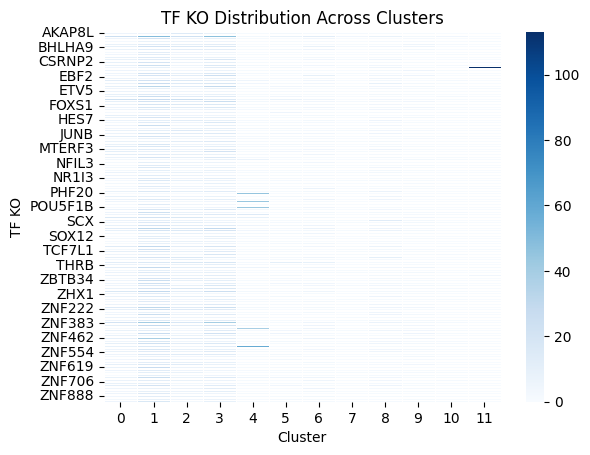

In [242]:
sns_heatmap(cluster_05_cluster_by_tf_ko.T)

In [237]:
def sns_stacked_bar(df_pivot):
    # Plot a stacked bar plot
    df_pivot.plot(kind='bar', stacked=True, figsize=(15, 6), cmap="rainbow")

    # Add labels and title
    plt.xlabel('Cluster')
    plt.ylabel('Number of Cells')
    plt.title('Number of TF Knockouts per Cluster')
    plt.legend(bbox_to_anchor=(1,1), ncols=10)

    # Show the plot
    plt.show()

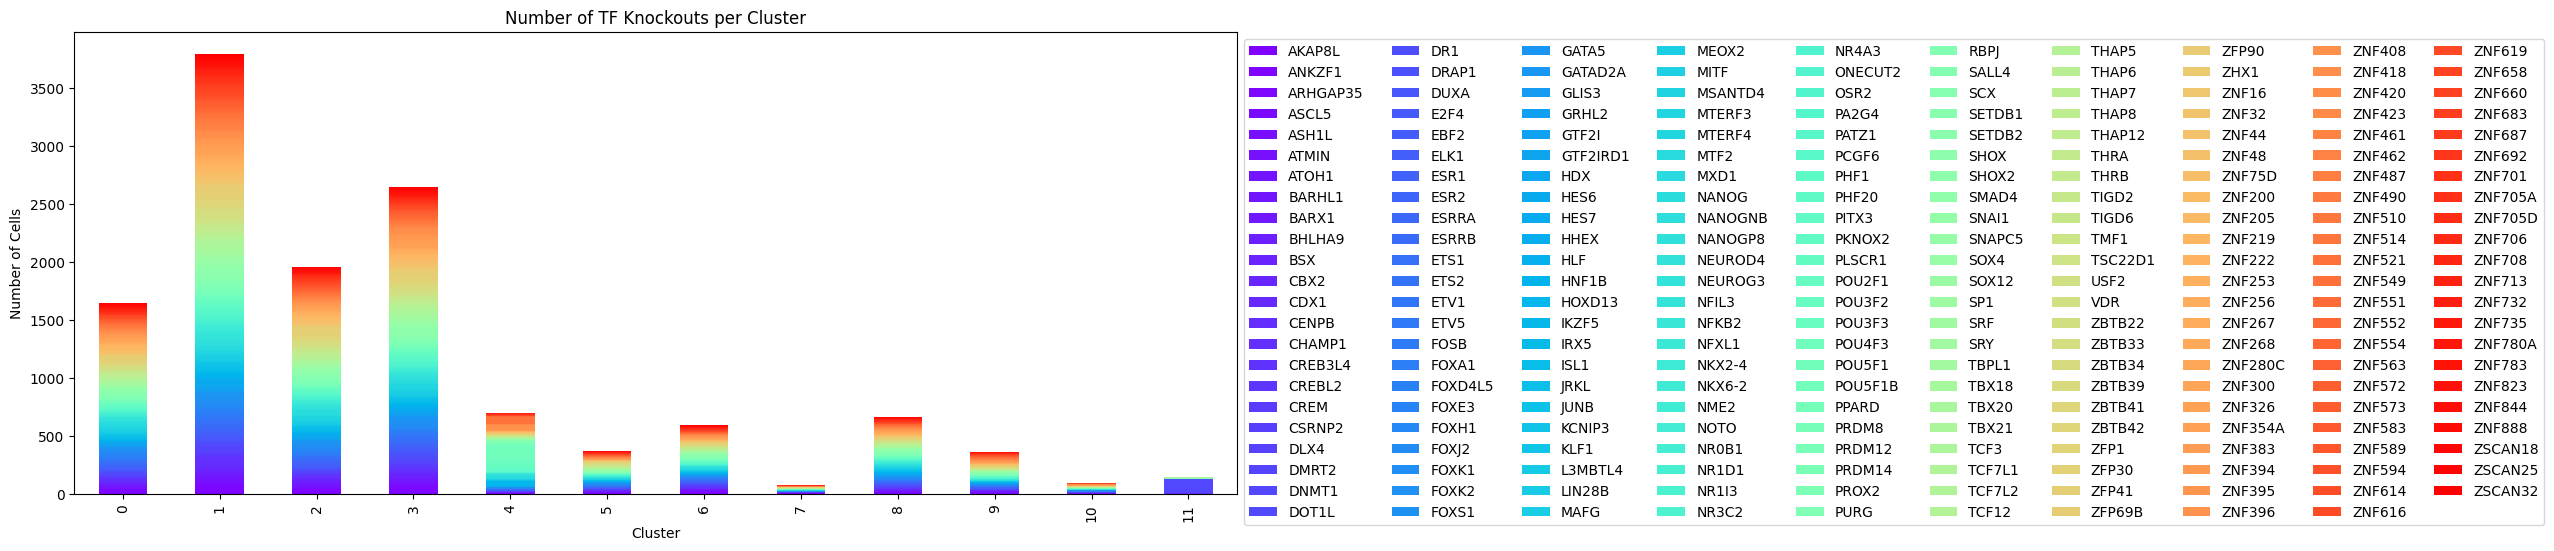

In [240]:
sns_stacked_bar(cluster_05_cluster_by_tf_ko)

Now we will write some functions to turn the data into "long" data and plot the long data:

In [230]:
def df_single_header(df_cluster_by_tf_ko):
    reset = df_cluster_by_tf_ko.reset_index()
    reset.columns.name = None
    reset.rename(columns={reset.columns[0]: "Cluster"}, inplace=True)
    return reset

def df_long(df_single_header):
    return df_single_header.melt(id_vars='Cluster', var_name='TF_KO', value_name='Count')

In [231]:
df_single_header_05 = df_single_header(cluster_05_cluster_by_tf_ko)
df_single_header_05

Cluster  AKAP8L  ANKZF1  ARHGAP35  ASCL5  ASH1L  ATMIN  ATOH1  BARHL1  \
0        0       6       6        25      6      4      2     10       8   
1        1       6      14        49     20     17      8     20      13   
2        2      15       5        23      6      5      7     11      10   
3        3       8       4        47      9     15      6     15      12   
4        4       1       1         3      1      0      0      3       0   
5        5       3       1         8      0      0      1      4       1   
6        6       2       5        12      4      1      2      4       2   
7        7       2       0         4      0      0      0      0       1   
8        8       1       3         8      0      4      2      4       1   
9        9       1       1         3      2      1      2      4       5   
10      10       0       0         4      0      0      0      0       2   
11      11       0       0         0      0      0      1      0       0   

    BARX1  ...  ZNF732  ZNF735  ZNF780A  ZNF783  ZNF823  ZNF844  ZNF888  \
0      10  ...       4       5        5       4       5       9       4   
1      22  ...      18       8       10      10      14      28      12   
2      16  ...       5       7        2       7       5      20       8   
3      16  ...       7      12        5      11       5      10       7   
4       1  ...       0       0        1       0       1       1       1   
5       0  ...       0       0        3       0       0       1       1   
6       8  ...       5       6        1       3       0       2       3   
7       2  ...       0       0        0       0       0       0       0   
8       4  ...       1       2        4       1       1       4       1   
9       5  ...       2       2        2       1       0       3       1   
10      0  ...       0       0        0       0       0       0       0   
11      0  ...       0       0        0       0       0       0       0   

    ZSCAN18  ZSCAN25  ZSCAN32  
0        10        3        6  
1        23        9       17  
2         6        4        3  
3         9        7        9  
4         1        0        1  
5         4        2        1  
6         1        1        2  
7         1        0        0  
8         3        0        2  
9         0        1        1  
10        1        0        1  
11        0        0        0  

[12 rows x 230 columns]

In [232]:
df_long(df_single_header_05)

Cluster    TF_KO  Count
0          0   AKAP8L      6
1          1   AKAP8L      6
2          2   AKAP8L     15
3          3   AKAP8L      8
4          4   AKAP8L      1
...      ...      ...    ...
2743       7  ZSCAN32      0
2744       8  ZSCAN32      2
2745       9  ZSCAN32      1
2746      10  ZSCAN32      1
2747      11  ZSCAN32      0

[2748 rows x 3 columns]

In [236]:
def sns_dotplot(df_long):
    # Create the dot plot
    sns.scatterplot(data=df_long, x="Cluster", y="TF_KO", size="Count", hue="Count", palette="viridis", edgecolor="black")

    # Rotate x-axis labels if needed for better readability
    plt.xticks(rotation=90)

    # Add labels and title
    plt.xlabel("Cluster")
    plt.ylabel("Transcription Factor Knockout (TF_KO)")
    plt.title("Transcription Factor Knockouts per Cluster")

    # Show the plot
    plt.show()

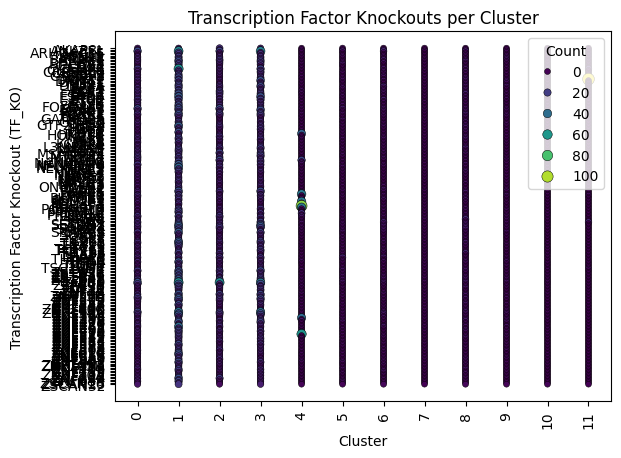

In [238]:
sns_dotplot(df_long(df_single_header_05))

In [ ]:
def sns_multi_histogram(df_long):
    # Step 1: Pivot the dataframe so that rows represent clusters, columns represent TF_KOs, and values are the number of cells per TF KO
    df_pivot = df_long.pivot_table(index='Cluster', columns='TF_KO', values='Count', aggfunc='sum', fill_value=0)

    # Step 2: For each cluster, count how many TF KOs appear in 1 cell, 2 cells, etc.
    # This will give us a distribution for each cluster: how many TF KOs are in exactly 1 cell, 2 cells, etc.
    cell_counts = df_pivot.apply(lambda x: x.value_counts(), axis=1).fillna(0).astype(int)

    # Step 3: Set up the subplots
    n_clusters = len(cell_counts)
    fig, axes = plt.subplots(n_clusters, 1, figsize=(8, 4 * n_clusters), sharex=True, sharey=False)

    # Step 4: Loop through each cluster and plot a histogram
    for i, cluster in enumerate(cell_counts.index):
        # Get the counts of TF KOs in 1, 2, 3, etc. cells for the current cluster
        cluster_counts = cell_counts.loc[cluster]

        # Filter out TF KOs with 0 cells in the cluster
        cluster_counts = cluster_counts[cluster_counts > 0]

        # Plot the histogram for the current cluster if there are any non-zero counts
        if len(cluster_counts) > 0:
            axes[i].bar(cluster_counts.index, cluster_counts.values, width=0.8, color='skyblue', edgecolor='black')

            # Set dynamic limits for the x-axis to "zoom in" based on the actual values for the current cluster
            axes[i].set_xlim(-1, max(cluster_counts.index) + 0.5)

            # Set dynamic limits for the y-axis to "zoom in" based on the actual counts for the current cluster
            axes[i].set_ylim(0, max(cluster_counts.values) * 1.1)  # Add a little space above the highest bar

            # Customize the plot for the current cluster
            axes[i].set_title(f'Cluster {cluster}')
            axes[i].set_xlabel('Number of Cells per TF KO')
            axes[i].set_ylabel('Number of TF KOs')
            plt.xticks()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

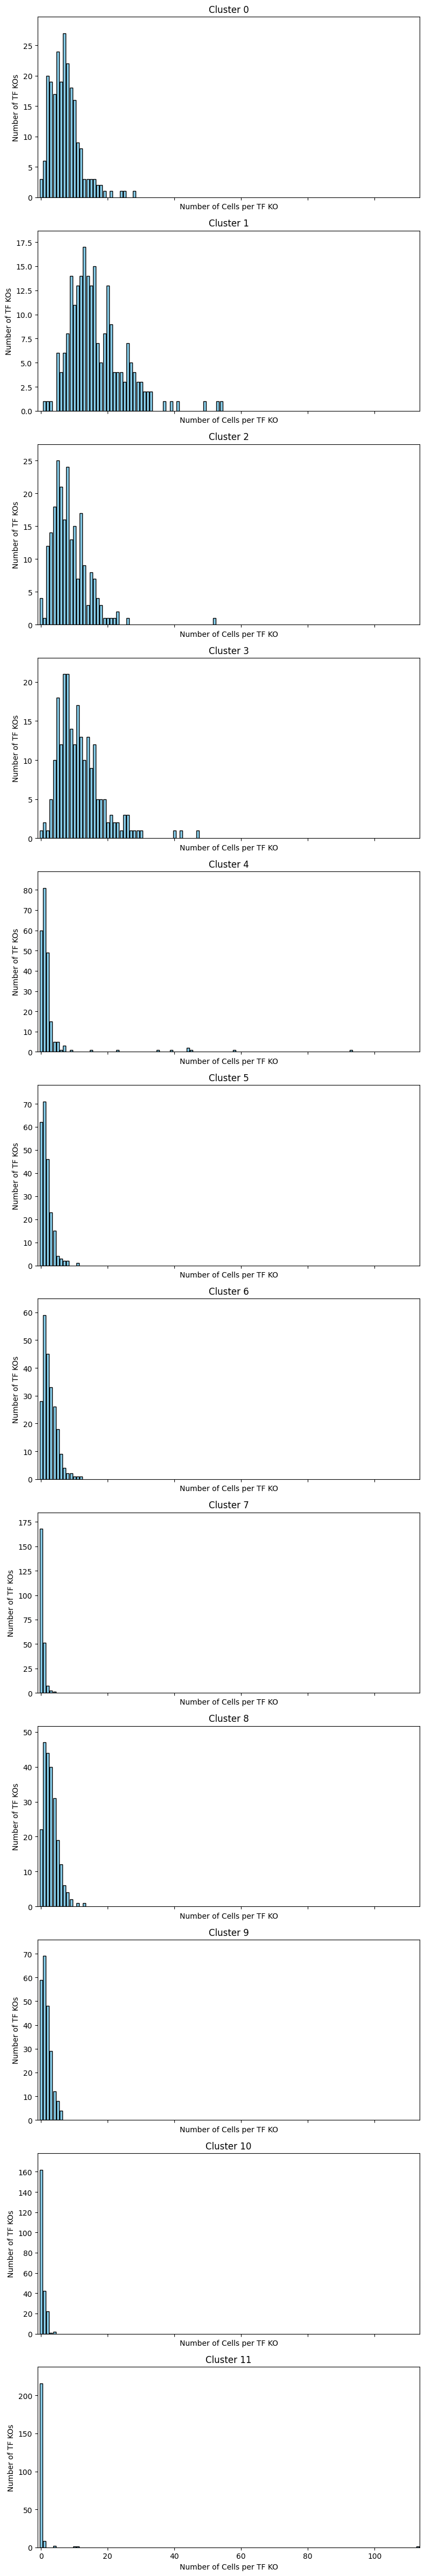

In [239]:
sns_multi_histogram(df_long(df_single_header_05))

With the Leiden clustering resolution of 0.5, some of the 11 clusters have a low numbers or occurrences of TF KOs. We will generate the same tables with a lower resolution of 0.40 that resulted in 9 clusters.

In [66]:
cluster_9_tf_kos = cluster_summary_tf_ko_df(cluster_summary_df("leiden_res_0.40"))
cluster_9_tf_kos_counts_df = tf_ko_cluster_df(cluster_9_tf_kos, 50)
cluster_9_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0   ARHGAP35    69     ZFP41   119  ARHGAP35    11    POU5F1    94     ZFP41   
1    ZNF354A    58  ARHGAP35    82    SETDB1    11    ZNF521    60    THAP12   
2      ZFP41    55    CHAMP1    82      E2F4    10     PHF20    45     FOXH1   
3      SHOX2    37     FOXH1    64    THAP12     9    POU3F2    44     GRHL2   
4     ZBTB22    36   ZNF354A    59     BARX1     8   POU5F1B    44      CBX2   
5      DOT1L    35     SHOX2    57      ETV1     8    ZNF396    39  ARHGAP35   
6       ETS1    35    ZNF219    57     PATZ1     7    HOXD13    35    MTERF4   
7     ZFP69B    34     NFIL3    56    SETDB2     7     NANOG    22    ZBTB22   
8     ZNF383    34    ZNF462    56     SHOX2     7    PRDM14    14      CREM   
9     CHAMP1    32    ZNF75D    54    ZNF383     7      PURG     8     DOT1L   
10     FOXJ2    31     FOXS1    53    ZNF462     7   NANOGP8     7      EBF2   
11    SETDB1    31     TBX20    53    CHAMP1     6      RBPJ     7      ETS1   
12      ETV1    30   NEUROD4    52      DLX4     6    SETDB2     6     FOXS1   
13     PCGF6    30      SOX4    52     DOT1L     6    ZNF418     6      MTF2   
14      SHOX    30    ZBTB22    52    POU2F1     6      ESR1     5     NFIL3   
15    ZNF75D    30      ZFP1    52     SNAI1     6   NEUROD4     5     PCGF6   
16     FOXH1    29      ETS1    51      SOX4     6     TIGD2     5    POU3F3   
17      SOX4    28     PCGF6    51      ZFP1     6     ESRRA     4      SHOX   
18      ZFP1    28    ZFP69B    49     ZFP41     6     SMAD4     4      SOX4   
19    ZNF219    28    ZNF394    49    ZNF394     6    ZBTB22     4    ZBTB41   
20    MTERF4    27    ZNF844    49    ZNF735     6      ZHX1     4      ZFP1   
21    THAP12    27    ZNF383    48       BSX     5    ZNF75D     4    ZNF408   
22     BARX1    26     ESRRA    47      CREM     5    ZNF701     4    ZNF420   
23      E2F4    26      HES6    47     FOXH1     5  ARHGAP35     3    ZNF701   
24    ZNF394    26   FOXD4L5    46      MXD1     5     ATOH1     3    ZNF713   
25     FOXS1    25      PURG    45     PCGF6     5      CBX2     3   ZSCAN18   
26    BHLHA9    24     TIGD2    45    SNAPC5     5    CHAMP1     3     ATOH1   
27     PITX3    24    ZNF222    45     THAP6     5     FOXS1     3     DNMT1   
28    ZNF420    24      ESR1    44     TIGD2     5     IKZF5     3      FOSB   
29   NEUROD4    23      ETV1    43    ZFP69B     5      ISL1     3      HES6   
30     TBX18    23     TBX18    43   ZNF354A     5     PPARD     3      OSR2   
31     TBX20    23     FOXJ2    42    ZNF396     5    ZFP69B     3    PKNOX2   
32    ZNF205    23     NANOG    42    ZNF701     5    ZNF219     3     SMAD4   
33    ZNF418    23   MSANTD4    41    ANKZF1     4    ZNF487     3       SRF   
34    ZNF510    23     THAP6    41    CREBL2     4    ZNF658     3       VDR   
35     DMRT2    22     BARX1    40      EBF2     4    BHLHA9     2    ZBTB39   
36     DNMT1    22    BHLHA9    40      ESR1     4     DMRT2     2     ZNF16   
37      RBPJ    22     SMAD4    40      ESR2     4      DUXA     2    ZNF383   
38     SMAD4    22     ZFP30    40     FOXJ2     4      ESR2     2    ZNF395   
39     ZFP30    22    ZNF418    40     FOXK1     4      FOSB     2    ZNF490   
40     ATOH1    21      FOSB    39     GATA5     4     FOXH1     2    ZNF563   
41    CREBL2    21     FOXK2    39      HES6     4     FOXJ2     2    ZNF583   
42      EBF2    21    ZNF701    39      HES7     4   GATAD2A     2   ZNF780A   
43     ESRRA    21      DUXA    38      ISL1     4      HES7     2    AKAP8L   
44      JRKL    21      MTF2    38      JRKL     4       HLF     2       BSX   
45    ZNF701    21      SHOX    38   MSANTD4     4      JRKL     2      ELK1   
46      MAFG    20     DOT1L    37    MTERF3     4    KCNIP3     2      ETS2   
47   MSANTD4    20    THAP12    37     NANOG     4   L3MBTL4     2     FOXJ2   
48 

Visualize the UMAP for this resolution

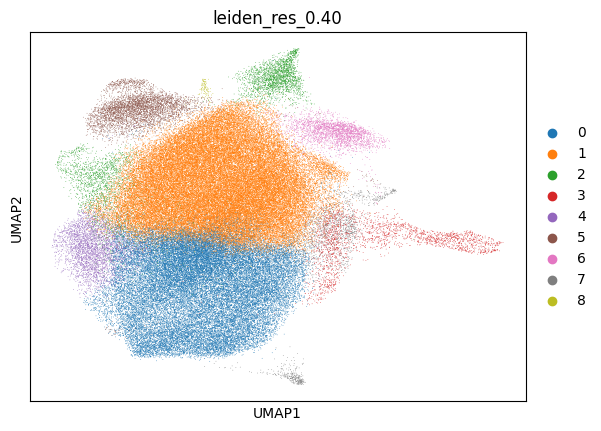

In [67]:
sc.pl.umap(adata, color="leiden_res_0.40")

Save speadsheets:

In [69]:
cluster_12_tf_kos_counts_df.to_csv("/home/ranwyl/results_tf_project/all_tf_kos_9_clusters.csv")

# UMAP with LFC filter for DEGs

For this UMAP, we will filter for DEGs with a |LFC| > 0.25 

In [17]:
adata = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Strong_Perturbations_Batch_Normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 111902 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

Write a feature selection function to only consider DEGs with |LFC| > 0.25, modifying the pipeline function:

In [14]:
def extract_degs_lfc_threshold(combined_df, up_degs, down_degs):
    up_down_degs = set()
    perturbations = [col.split('_DEGs')[0] for col in combined_df.columns if '_DEGs' in col]
    
    for perturbation in perturbations:
        # Select the DEGs and L2FC columns for the perturbation
        degs_col = f'{perturbation}_DEGs'
        l2fc_col = f'{perturbation}_L2FC'
        
        # Create a DataFrame for the perturbation
        perturbation_df = combined_df[[degs_col, l2fc_col]].dropna()
        
        # Extract top x upregulated DEGs
        upregulated_df = perturbation_df[perturbation_df[l2fc_col] > 0.25].sort_values(by=l2fc_col, ascending=False).head(up_degs)
        top_upregulated = upregulated_df[degs_col].tolist()
        
        # Extract top y downregulated DEGs
        downregulated_df = perturbation_df[perturbation_df[l2fc_col] < 0.25].sort_values(by=l2fc_col, ascending=True).head(down_degs)
        top_downregulated = downregulated_df[degs_col].tolist()
        
        # Combine the results
        up_down_degs.update(top_upregulated + top_downregulated)
    
    # Return the subset of adata containing only the DEGs
    return up_down_degs


def feature_selection_lfc_threshold(adata, DEG_df, up_DEGs=20, down_DEGs=20):
    # Select top_n_DEGs for each perturbation, or the maximum possible if fewer than top_n_DEGs
    top_DEGs = extract_degs_lfc_threshold(DEG_df, up_DEGs, down_DEGs)
    
    # Filter out any None or NaN values that may have been introduced
    deg_values = [gene for gene in top_DEGs if pd.notnull(gene)]
    unique_degs = set(deg_values)
    print(f"Found {len(unique_degs)} DEGs with |LFC| > 0.25")

    # Return the subset of adata containing only the HVGs
    return adata[:, adata.var.index.isin(unique_degs)].copy()

Now we will filter HVGs with |LFC| > 0.25

In [18]:
adata_filtered = feature_selection_lfc_threshold(adata, deg_df)

Found 3521 DEGs with |LFC| > 0.25


Run PCA and plot elbow plot:

computing PCA
    with n_comps=50
    finished (0:00:11)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


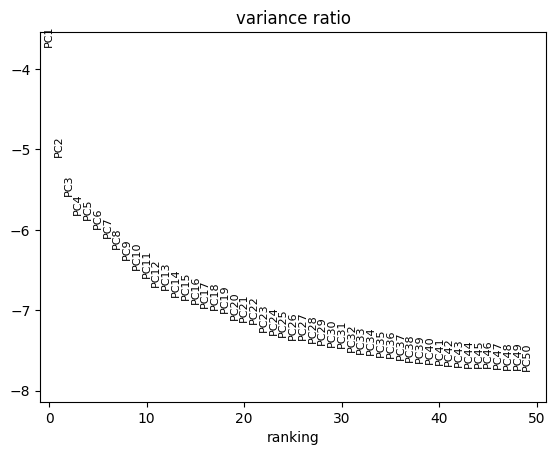

In [19]:
sc.tl.pca(adata_filtered)
sc.pl.pca_variance_ratio(adata_filtered, n_pcs=50, log=True) #Elbow plot

We will use the top 30 PCs for the neighborhood graph:

In [20]:
num_pcs = 30
sc.pp.neighbors(adata_filtered, n_pcs=num_pcs)
sc.tl.umap(adata_filtered)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:12)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:05)


We will perform Leiden clustering with 3 different resolutions:

In [21]:
for res in [0.5, 0.75, 1]:
    sc.tl.leiden(adata_filtered, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_res_0.75', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:03)


For the resolution = 0.75 condition, visualize the UMAP and TF KO table:

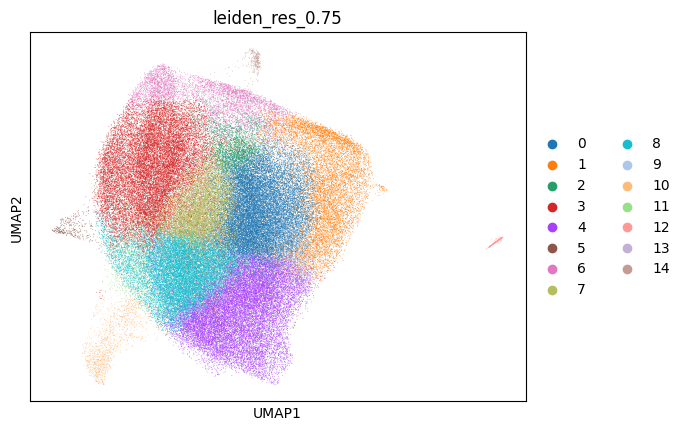

In [46]:
sc.pl.umap(adata_filtered, color="leiden_res_0.75")

In [48]:
cluster_filt_075_tf_kos_counts_df = tf_ko_cluster_df_from_adata(adata_filtered, "leiden_res_0.75", 50)
cluster_filt_075_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      ZFP41    36  ARHGAP35    20  ARHGAP35    15     DNMT1    29     ZFP41   
1    ZNF354A    33     ZFP41    19     ZFP41    11     ZFP41    29  ARHGAP35   
2   ARHGAP35    28   ZNF354A    17     TBX20     8  ARHGAP35    26     SHOX2   
3      FOXH1    28      ETV1    15    ZNF383     8    CHAMP1    24    CHAMP1   
4       SHOX    24     PCGF6    15      E2F4     7    SETDB1    23     NFIL3   
5       ETS1    21    SETDB1    15     ATOH1     6     FOXH1    21   NEUROD4   
6      FOXS1    21      ETS1    14    CHAMP1     6    ZBTB22    20     PCGF6   
7      SHOX2    21     SMAD4    14     FOXS1     6   ZNF354A    19     ESRRA   
8     ZNF75D    21      SOX4    12     PCGF6     6     ATOH1    17     GATA5   
9     CHAMP1    20    ZNF462    12    THAP12     6     FOXS1    17      HES6   
10     DNMT1    20    CHAMP1    11      ZFP1     6      ZFP1    16   ZNF354A   
11     DOT1L    20    CREBL2    11     BARX1     5    ZNF205    16    ZNF844   
12     FOXK2    20      E2F4    11     DMRT2     5    ZNF383    16     TBX20   
13    SETDB1    20     TBX18    11     DNMT1     5    ZNF219    15      ZFP1   
14      SOX4    20    ZBTB22    11      ESR1     5      RBPJ    14    ZNF267   
15    THAP12    19    ZFP69B    11      ETS1     5     SHOX2    14     FOXH1   
16     TIGD2    19     SHOX2    10      JRKL     5    THAP12    14     FOXS1   
17    ZBTB22    19    ZBTB42    10      MITF     5     NFIL3    13    ZNF462   
18      ZFP1    19    ZNF75D    10    MTERF4     5     TBX20    13      ETS1   
19     ESRRA    18    ZNF200    10    SETDB1     5     THAP6    13   FOXD4L5   
20      ETV1    18    ZNF205    10     SMAD4     5    ZNF75D    13     THAP6   
21   NEUROD4    17    ZNF253    10    ZBTB22     5     BARX1    12     ZFP30   
22    POU2F1    17    BHLHA9     9    ZNF844     5      ETS1    12    ZFP69B   
23      PURG    17     FOXH1     9     ASH1L     4     FOXJ2    12    ZNF394   
24    SETDB2    17    MTERF4     9      CBX2     4     SALL4    12     TIGD2   
25    ZNF394    17     NANOG     9      EBF2     4    ZBTB39    12    ZNF75D   
26     PCGF6    16   NANOGNB     9      ESR2     4     ZFP30    12    ZNF219   
27     PITX3    16    ZNF219     9   FOXD4L5     4    ZFP69B    12    ZNF383   
28    ZNF420    16    ZNF394     9     FOXJ2     4    ZNF462    12    ZNF658   
29      FOSB    15    ZNF408     9      HHEX     4     DOT1L    11     BARX1   
30      MTF2    15    ZNF552     9      MAFG     4     SMAD4    11     FOXJ2   
31    ZNF222    15    ZNF701     9   NEUROD4     4     SNAI1    11     HNF1B   
32    ZNF383    15     ASCL5     8     NFIL3     4      SOX4    11      SHOX   
33    ZNF713    15      CBX2     8    NKX6-2     4    ZNF418    11     SMAD4   
34     BARX1    14     FOXJ2     8      RBPJ     4    ZNF701    11    ZNF510   
35    BHLHA9    14   MSANTD4     8      SOX4     4   FOXD4L5    10    BHLHA9   
36      ESR2    14      OSR2     8       VDR     4     GTF2I    10      ESR1   
37     FOXJ2    14     PITX3     8      ZHX1     4      ISL1    10      MAFG   
38     GATA5    14    TCF7L1     8    ZNF205     4      MAFG    10    NKX2-4   
39      HES6    14     TCF12     8    ZNF219     4   MSANTD4    10    ZBTB34   
40     NANOG    14     THAP6     8   ZNF354A     4      MTF2    10    ZNF418   
41     ZFP30    14      ZHX1     8    ZNF394     4     PITX3    10    ZNF420   
42    ZFP69B    14     ZNF32     8    ZNF510     4    POU3F3    10    ZNF701   
43    ZNF219    14     ZNF44     8    ZNF573     4      PURG    10      ISL1   
44    ZNF510    14    ZNF420     8    ZNF701     4    SETDB2    10    PRDM12   
45     DMRT2    13    ZNF619     8    ZNF732     4     THAP5    10    SETDB2   
46      E2F4    13     BARX1     7    BHLHA9     3    ZNF573    10      SOX4   
47     FOXK1    13       BSX     7      CREM     3   ZSCAN18    10    ZBTB33   
48 

We will further filter the TF KO table that shows n_tf_kos per cluster so that:
-  For a given cluster, only TF KOs with more than 10 cells are considered
-  Only clusters with more than (10 * n_tf_kos) total cells are considered

In [ ]:
def filter_tf_ko_df(tf_ko_df, cells_per_tf_ko):
    """
    Filter

Leiden clustering with resolution = 0.5 yielded 9 clusters. Visualize this UMAP:

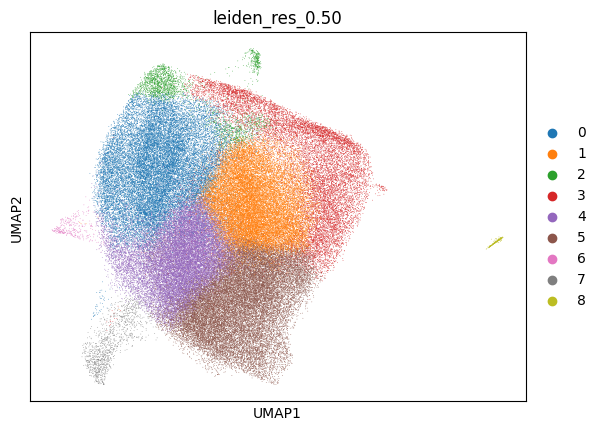

In [22]:
sc.pl.umap(adata_filtered, color="leiden_res_0.50")

Generate TF KO table:

In [40]:
cluster_filt_9_tf_kos_counts_df = tf_ko_cluster_df_from_adata(adata_filtered, "leiden_res_0.50", 20)
cluster_filt_9_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      ZFP41    36  ARHGAP35    38  ARHGAP35    12  ARHGAP35    26     DNMT1   
1      DNMT1    30     ZFP41    38    ZNF383    10     ZFP41    24     ZFP41   
2   ARHGAP35    29   ZNF354A    33     ZFP41     8   ZNF354A    22  ARHGAP35   
3     CHAMP1    28     FOXH1    29    CHAMP1     6    ZFP69B    20    CHAMP1   
4     ZBTB22    26    THAP12    29      EBF2     6    SETDB1    18    ZNF462   
5      FOXH1    25     DNMT1    28      ESR1     6     PCGF6    17     NANOG   
6     SETDB1    24    CHAMP1    24     DMRT2     5      E2F4    16    ZBTB22   
7    ZNF354A    23      ZFP1    24     FOXS1     5      ETS1    15     DOT1L   
8      FOXS1    22     FOXK2    23     TBX20     5      ETV1    15   ZNF354A   
9       SOX4    19     DOT1L    22    ZNF521     5     SHOX2    15      ETV1   
10    ZNF205    19     FOXS1    22    BARHL1     4     SMAD4    15     PCGF6   
11    ZNF219    19   NEUROD4    22      ETS1     4     NANOG    14      E2F4   
12    ZNF383    19     PCGF6    22      MITF     4    ZNF75D    14     ESRRA   
13     ATOH1    18      ETS1    21     NFIL3     4    ZBTB22    13     TIGD2   
14      ZFP1    18      ETV1    21    PRDM12     4    ZNF462    13    ZNF219   
15      RBPJ    17     PITX3    21    SETDB1     4    BHLHA9    12    ZNF383   
16    ZNF75D    17      PURG    21    ZBTB22     4    CREBL2    12    ZNF418   
17     BARX1    16    SETDB1    21    ZNF75D     4     DOT1L    12     NFIL3   
18      ETS1    16     SHOX2    21   ZNF354A     4     FOXH1    12      SOX4   
19    THAP12    16      SOX4    21    AKAP8L     3    MTERF4    12     FOXH1   

         cluster 5       cluster 6       cluster 7       cluster 8        
   count     TF KO count     TF KO count     TF KO count     TF KO count  
0     69     ZFP41    61     ZFP41     3    POU5F1    93     ATOH1     3  
1     36  ARHGAP35    44      ESR1     2    ZNF521    52      E2F4     3  
2     33     SHOX2    38     FOXK1     2     PHF20    45     FOXH1     3  
3     31    CHAMP1    35      HES6     2    POU3F2    43     ZNF32     3  
4     30    ZNF844    32      HES7     2   POU5F1B    43      CBX2     2  
5     27     THAP6    30      MTF2     2    ZNF396    38   CREB3L4     2  
6     26    ZFP69B    30     TIGD6     2    HOXD13    35      MXD1     2  
7     25     ESRRA    29    ZFP69B     2     NANOG    15   NEUROD4     2  
8     24      HES6    29    ZNF75D     2    PRDM14    12    SETDB2     2  
9     23   ZNF354A    29   ZNF354A     2      PURG    12       SRF     2  
10    23     NFIL3    28    ZNF383     2      RBPJ     6      ZHX1     2  
11    22     PCGF6    28    ZNF614     2     FOXS1     5  ARHGAP35     1  
12    22     TBX20    28    ZNF692     2   NANOGP8     5     ASH1L     1  
13    22      ZFP1    28    AKAP8L     1   NEUROD4     4     BARX1     1  
14    22    ZNF219    28    BARHL1     1    SETDB2     4    BHLHA9     1  
15    21    ZNF510    28     BARX1     1      ZHX1     4      EBF2     1  
16    20      ETS1    27       BSX     1    ZNF418     4      ELK1     1  
17    19     FOXH1    27     CENPB     1  ARHGAP35     3      ESR1     1  
18    19   NEUROD4    27    CREBL2     1     ATOH1     3      ETS1     1  
19    18    ZNF394    27     DOT1L     1      CBX2     3     FOXK2     1

Some clusters still have few TFs, so we will run Leiden clustering again at lower resolutions:

In [41]:
for res in [0.2, 0.3, 0.4]:
    sc.tl.leiden(adata_filtered, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res_0.20', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res_0.30', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res_0.40', the cluster labels (adata.obs, categorical) (0:00:03)


Display the TF KO table for the resolution=0.20 condition

In [43]:
cluster_filt_03_tf_kos_counts_df = tf_ko_cluster_df_from_adata(adata_filtered, "leiden_res_0.30", 20)
cluster_filt_03_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0   ARHGAP35    67     ZFP41    99  ARHGAP35    40     ESRRB     1  ARHGAP35   
1      ZFP41    64     DNMT1    77     ZFP41    40     SNAI1     1    CHAMP1   
2      DNMT1    55  ARHGAP35    70   ZNF354A    37     TIGD6     1      ESR1   
3      FOXH1    48    CHAMP1    65     NANOG    29    ZBTB42     1     ZFP41   
4     CHAMP1    46   ZNF354A    55      SHOX    26    ZNF844     1    ZNF383   
5     SETDB1    44    ZNF462    53      ETS1    25                    AKAP8L   
6    ZNF354A    44     SHOX2    51    ZFP69B    25                    BARHL1   
7     ZBTB22    43      HES6    49     SHOX2    24                     DMRT2   
8      DOT1L    40    ZNF219    48    SETDB1    23                      EBF2   
9       ZFP1    40     ESRRA    47    ZNF75D    23                     NFIL3   
10    ZNF383    40     FOXH1    45    ZNF394    23                   FOXD4L5   
11     FOXS1    37     NFIL3    45      ETV1    22                     FOXE3   
12     PCGF6    37    ZNF383    45     SMAD4    22                     FOXH1   
13      SOX4    37      ETS1    44      E2F4    21                     FOXK1   
14    THAP12    37      SOX4    44     PCGF6    21                     FOXS1   
15    ZNF75D    35     TBX20    44    CHAMP1    20                      HES6   
16   NEUROD4    33    ZNF844    44     FOXS1    20                    KCNIP3   
17     TBX20    33     FOXJ2    43    ZBTB22    20                    MTERF4   
18     SHOX2    32    ZFP69B    43    CREBL2    19                    PRDM12   
19    ZNF205    32     PCGF6    42     DOT1L    19                       SCX   

         cluster 5       cluster 6        
   count     TF KO count     TF KO count  
0      5    POU5F1    92     ATOH1     3  
1      4    ZNF521    52      E2F4     3  
2      4     PHF20    45     FOXH1     3  
3      4    POU3F2    43     ZNF32     3  
4      4   POU5F1B    43      CBX2     2  
5      3    ZNF396    37   CREB3L4     2  
6      3    HOXD13    35      MXD1     2  
7      3     NANOG     8   NEUROD4     2  
8      3    PRDM14     6    SETDB2     2  
9      3      RBPJ     6       SRF     2  
10     2   NEUROD4     4      ZHX1     2  
11     2      ZHX1     4  ARHGAP35     1  
12     2    ZNF418     4     ASH1L     1  
13     2  ARHGAP35     3     BARX1     1  
14     2     ATOH1     3    BHLHA9     1  
15     2      CBX2     3      EBF2     1  
16     2     FOXS1     3      ELK1     1  
17     2     NR1D1     3      ESR1     1  
18     2      PURG     3      ETS1     1  
19     2    SETDB2     3     FOXK2     1

Continue to run clustering with lower resolutions until we get a reasonable number of TF KOs per cluster:

In [44]:
for res in [0.05, 0.08, 0.1]:
    sc.tl.leiden(adata_filtered, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res_0.05', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res_0.08', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res_0.10', the cluster labels (adata.obs, categorical) (0:00:03)


In [45]:
cluster_filt_01_tf_kos_counts_df = tf_ko_cluster_df_from_adata(adata_filtered, "leiden_res_0.10", 20)
cluster_filt_01_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3      
       TF KO count     TF KO count     TF KO count     TF KO count
0      ZFP41   206     ATOH1     3    POU5F1    90  ARHGAP35     4
1   ARHGAP35   179      E2F4     3    ZNF521    46    CHAMP1     4
2      DNMT1   150     FOXH1     3     PHF20    44     NFIL3     3
3    ZNF354A   136     ZNF32     3   POU5F1B    42    ZNF383     3
4     CHAMP1   131      CBX2     2    POU3F2    41    BARHL1     2
5      FOXH1   112   CREB3L4     2    ZNF396    36     DMRT2     2
6      SHOX2   109      MXD1     2    HOXD13    32      EBF2     2
7     ZBTB22   105   NEUROD4     2      RBPJ     5      ESR1     2
8     ZNF383   102    SETDB2     2   NEUROD4     4   FOXD4L5     2
9       ETS1   100       SRF     2     ATOH1     3     FOXE3     2
10     PCGF6   100      ZHX1     2     FOXS1     3     FOXK1     2
11    ZNF75D   100  ARHGAP35     1      ZHX1     3     FOXS1     2
12    ZNF219    99     ASH1L     1  ARHGAP35     2      HES6     2
13      SOX4    98     BARX1     1     IKZF5     2    PRDM12     2
14      ZFP1    98    BHLHA9     1      ISL1     2     TCF12     2
15     FOXS1    97      EBF2     1     MEOX2     2     TIGD6     2
16    ZFP69B    97      ELK1     1      MXD1     2    ZBTB22     2
17    ZNF462    95      ESR1     1    SETDB2     2     ZFP30     2
18     NANOG    92      ETS1     1     SMAD4     2     ZFP41     2
19     DOT1L    91     FOXK2     1    TCF7L2     2    ZNF75D     2